In [2]:
import numpy as np
import pygimli as pg
from pygimli.physics import ert
from pygimli.physics.ert.importData import importRes2dInv
import matplotlib.pyplot as plt
import pygimli.meshtools as mt
from pygimli.frameworks import PriorModelling, JointModelling
from scipy.interpolate import interp1d
import pandas as pd
import pickle
from pygimli.viewer.mpl import draw1DColumn


In [3]:
dir='//smb.isipd.dmawi.de/projects/p_subaqua/Expeditions/2023/NWT2023/analysis_Tuk/Tuk_all_mehriban/'

In [4]:
data = ert.load('//smb.isipd.dmawi.de/projects/sparc/data/Sensors_Mobile/202307_DEPTHAW_InuvikTuk/IRISSyscalProSwitch/res2Dinv/ERT_data_eastern_amphibious_DAT_raw.txt')

In [5]:
data_topo = ert.load('//smb.isipd.dmawi.de/projects/sparc/data/Sensors_Mobile/202307_DEPTHAW_InuvikTuk/IRISSyscalProSwitch/res2Dinv/ERT_data_eastern_amphibious_DAT_no_std_filter_with_err.dat')

13/11/25 - 08:54:46 - pyGIMLi - INFO - could not read unified data format for ERT ... try res2dinv


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1cbb1cd5590>)

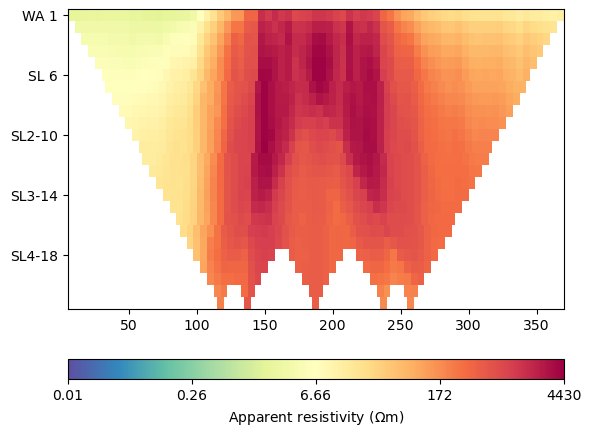

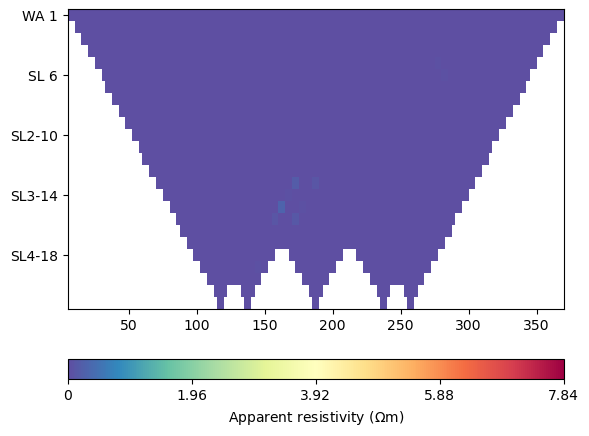

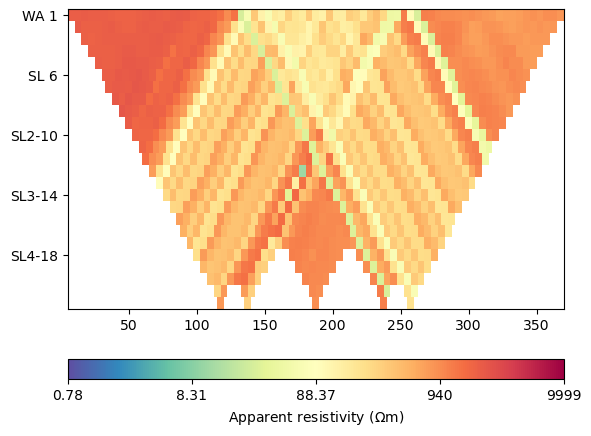

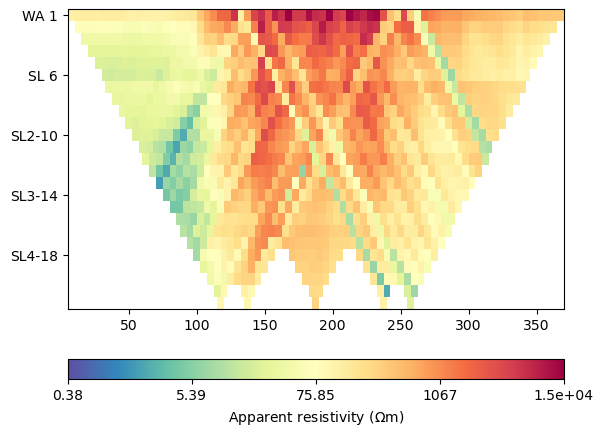

In [21]:
ert.show(data)
ert.show(data, data['err'])
ert.show(data, data['i'])
ert.show(data, data['u'])

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x149c8174310>)

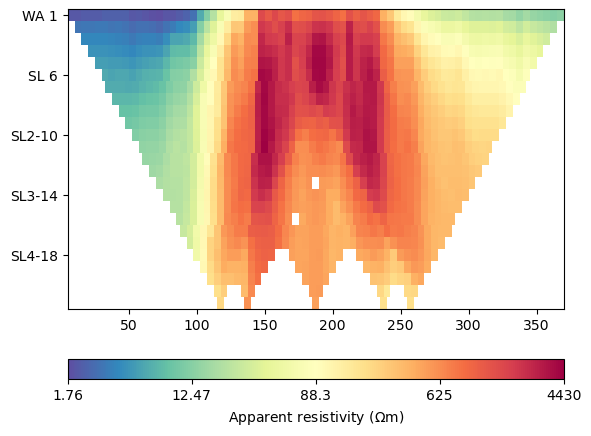

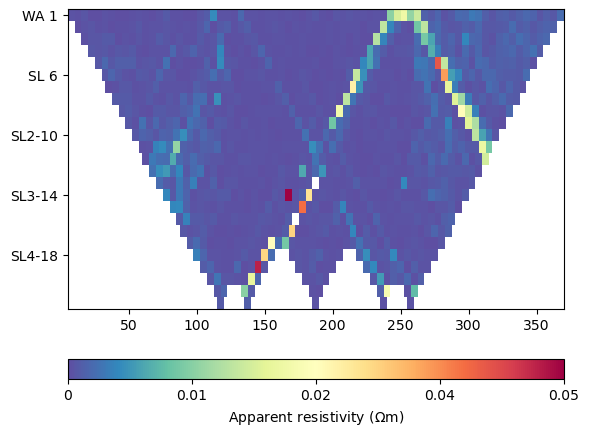

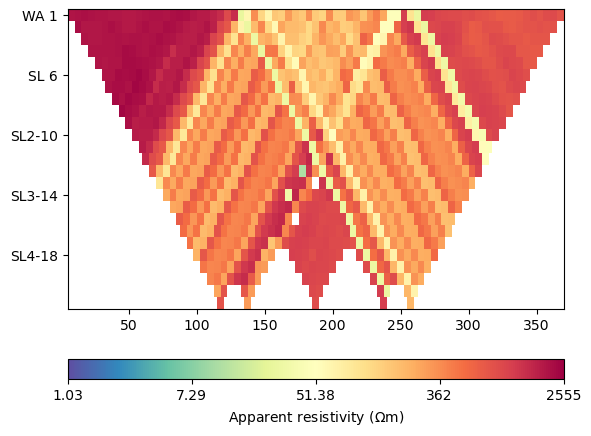

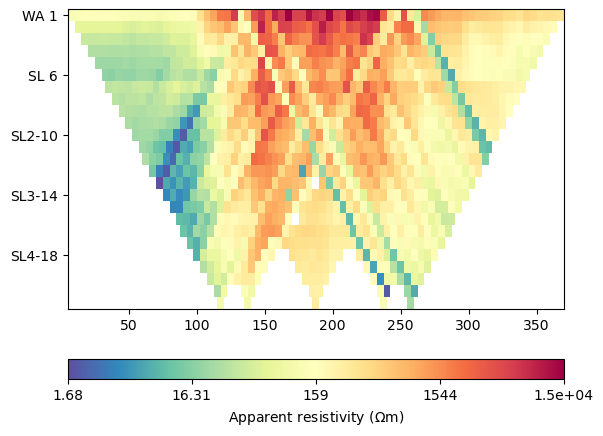

In [6]:
data.remove(data['err']>=0.05)
data.remove(data['i'] < 1)
data.remove(data['rhoa'] <= 0)
ert.show(data)
ert.show(data, data['err'])
ert.show(data, data['i'])
ert.show(data, data['u'])

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x149c9940b50>)

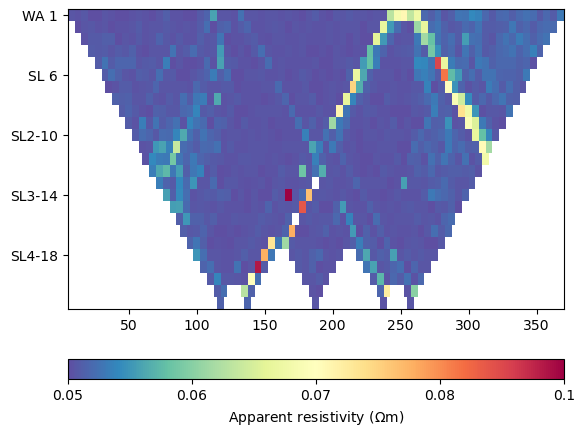

In [7]:
data['err'] = data['err'] + ert.estimateError(data, relativeError=0.05, absoluteUError=5e-4)
ert.show(data, data['err'])

In [8]:
data['k'] = ert.createGeometricFactors(data)
data.setSensorPositions(pg.meshtools.interpolateAlongCurve(data_topo.additionalPoints(), pg.x(data_topo)))
data['k_topo'] = ert.createGeometricFactors(data, numerical=True)

13/11/25 - 08:54:57 - pyGIMLi - INFO - Cache c:\Users\mealiy001\AppData\Local\miniconda3\envs\pgcore\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 38): C:\Users\mealiy001\AppData\Roaming\pygimli\Cache\14942455674779020467
13/11/25 - 08:54:57 - pyGIMLi - INFO - Cache c:\Users\mealiy001\AppData\Local\miniconda3\envs\pgcore\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (5.5s x 38): C:\Users\mealiy001\AppData\Roaming\pygimli\Cache\13820646509181069548


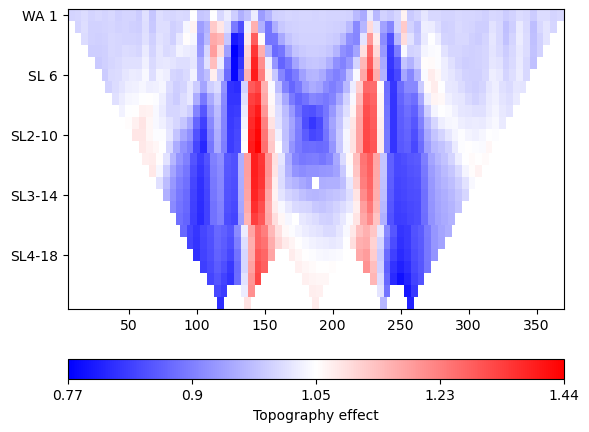

In [25]:
_ = ert.showData(data, vals=data['k_topo']/ data['k'], label='Topography effect',
                 logScale=True, cMap="bwr")

In [9]:
data['rhoa'] = data['r']*data['k_topo']

In [10]:
mgr = ert.ERTManager(data)

In [11]:
np.mean(data['rhoa'])

1088.345417646103

(-30.0, 390.0)

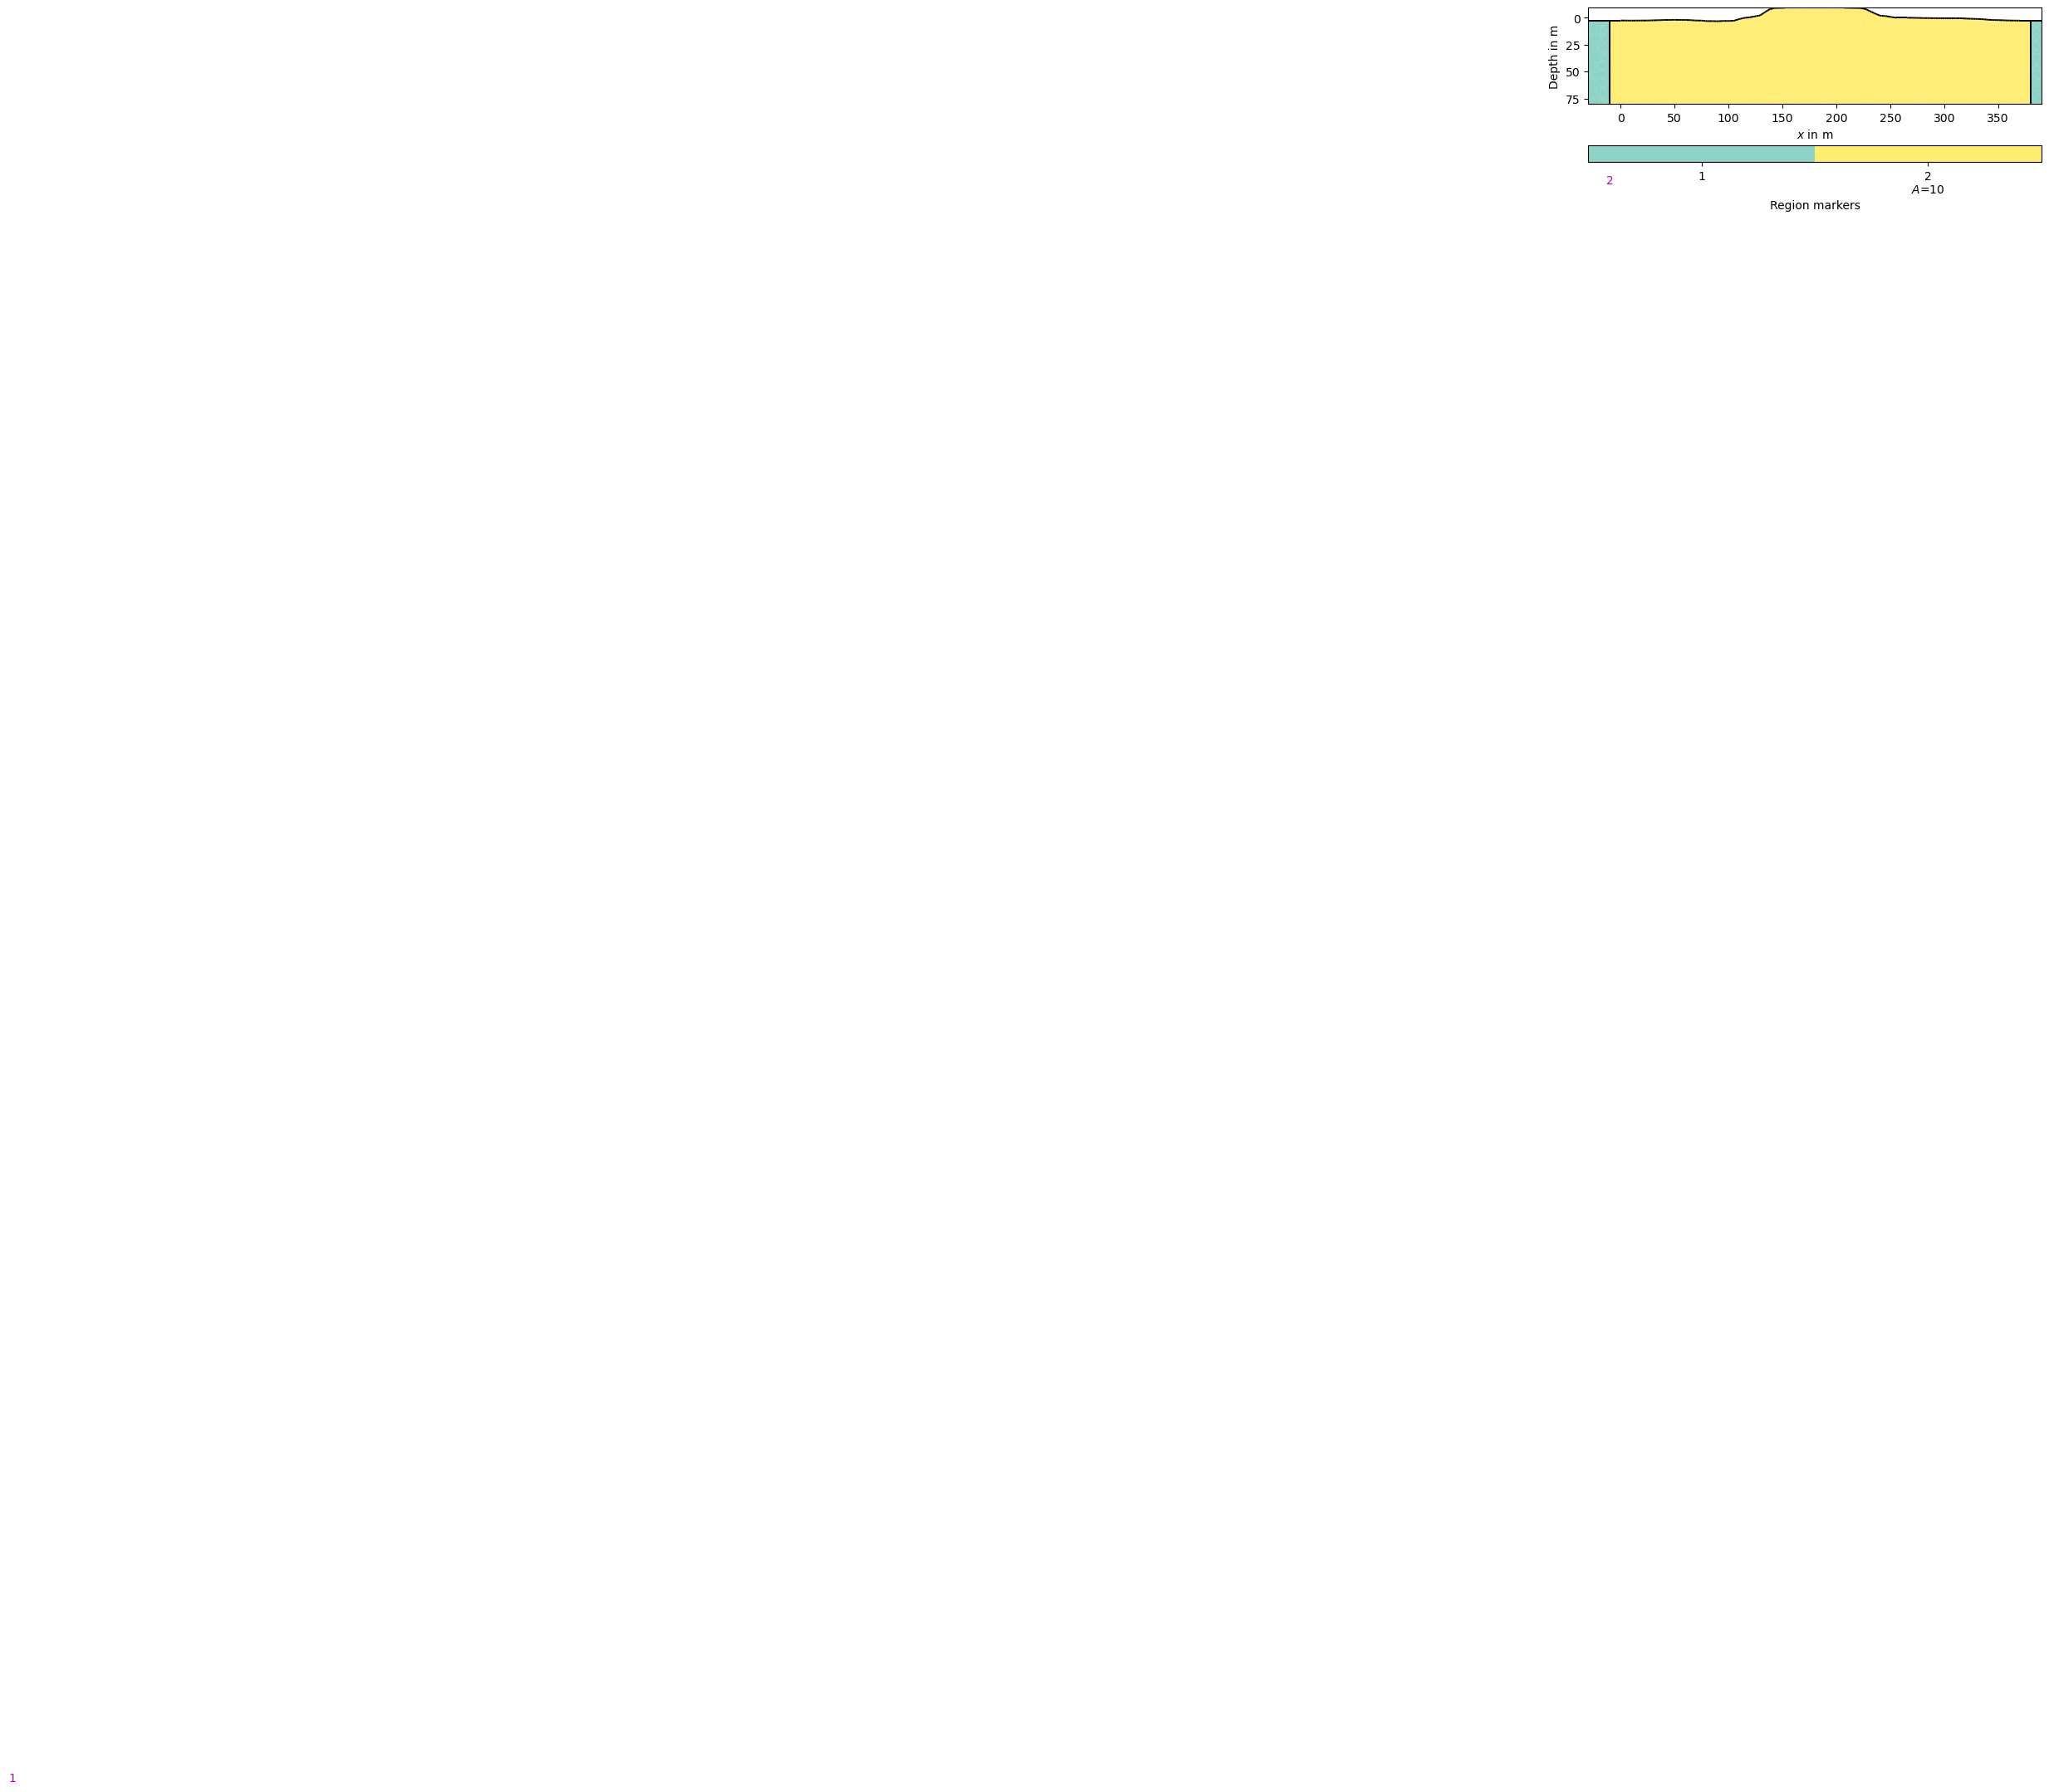

In [12]:
plc = mt.createParaMeshPLC(data, paraDX = 0.25, paraDZ= 0.25, paraMaxCellSize=10)

ax, _ = pg.show(plc)
ax.set_ylim(-80)
ax.set_xlim(-30,390)



(-10.0, 381.0)

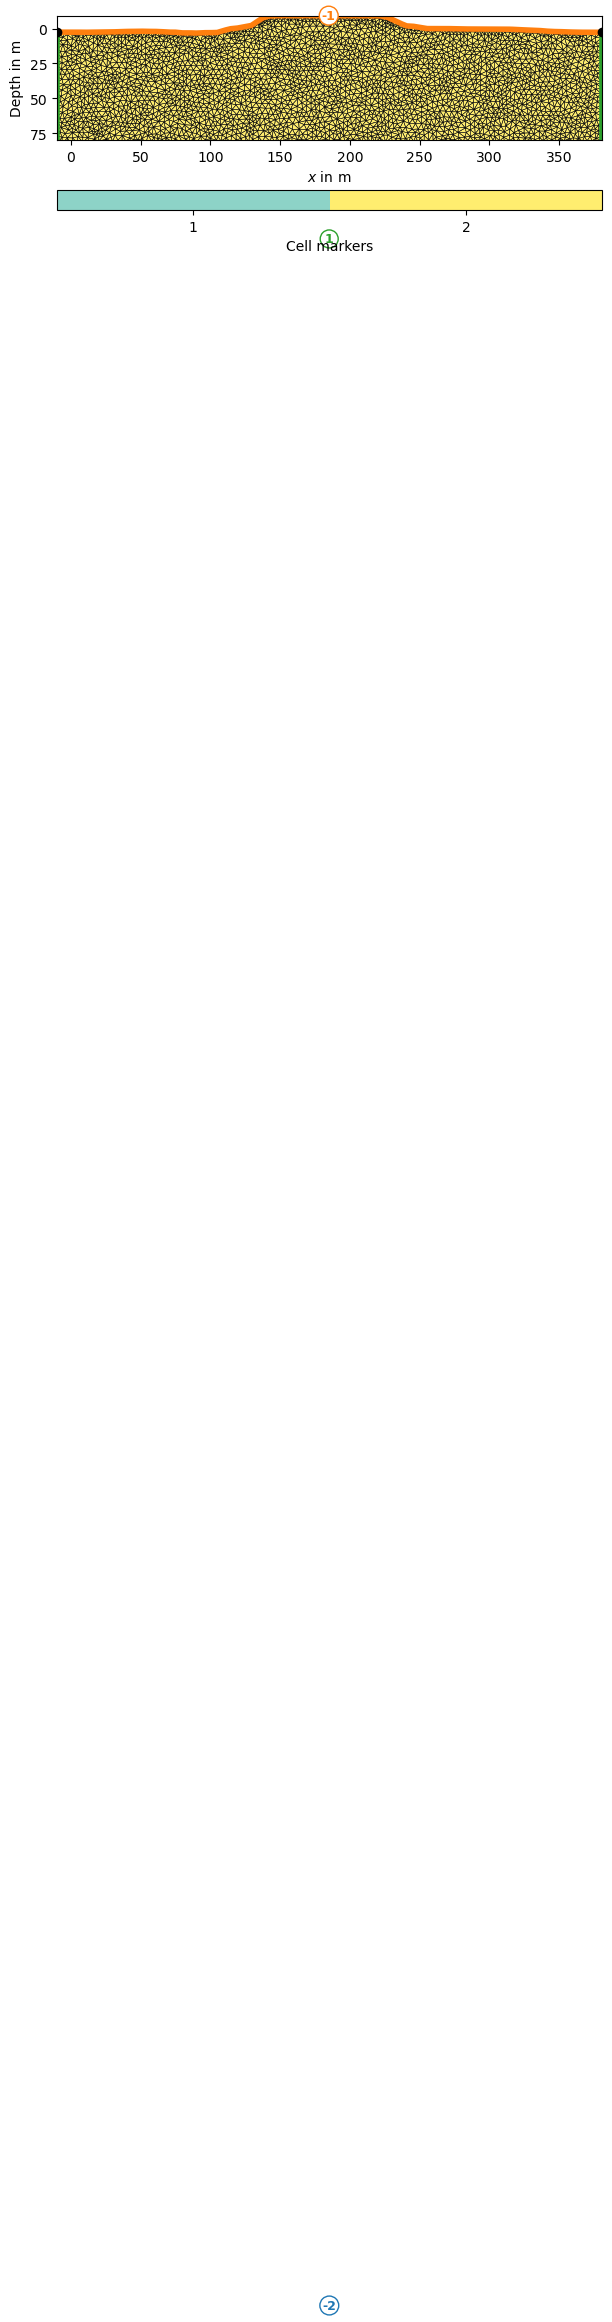

In [13]:
mesh = mt.createMesh(plc)
ax, _ = pg.show(mesh, markers=True, showMesh=True)
ax.set_ylim(-80)
ax.set_xlim(-10,381)

11/05/25 - 19:56:19 - pyGIMLi - INFO - Found 2 regions.
11/05/25 - 19:56:19 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
11/05/25 - 19:56:19 - pyGIMLi - INFO - Found 2 regions.
11/05/25 - 19:56:19 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
11/05/25 - 19:56:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
11/05/25 - 19:56:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
11/05/25 - 19:56:20 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 12050 Cells: 23556 Boundaries: 17938
11/05/25 - 19:56:20 - pyGIMLi - INFO - Use median(data values)=605.1544214116204
11/05/25 - 19:56:20 - pyGIMLi - INFO - Created startmodel from forward operator:4793, min/max=605.154421/605.154421
11/05/25 - 19:56:20 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001E27EDCA5C0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation: Logarithmic transform
min/max (data): 1.78/5564
min/max (error): 2%/2831%
min/max (start model): 605/605
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1725.27
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  154.68 (dPhi = 90.84%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   40.43 (dPhi = 73.50%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    9.47 (dPhi = 73.75%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    3.01 (dPhi = 57.49%) lam: 20.0
----------------------------------------------------

Text(129.2041457109214, 0.5, 'y (m)')

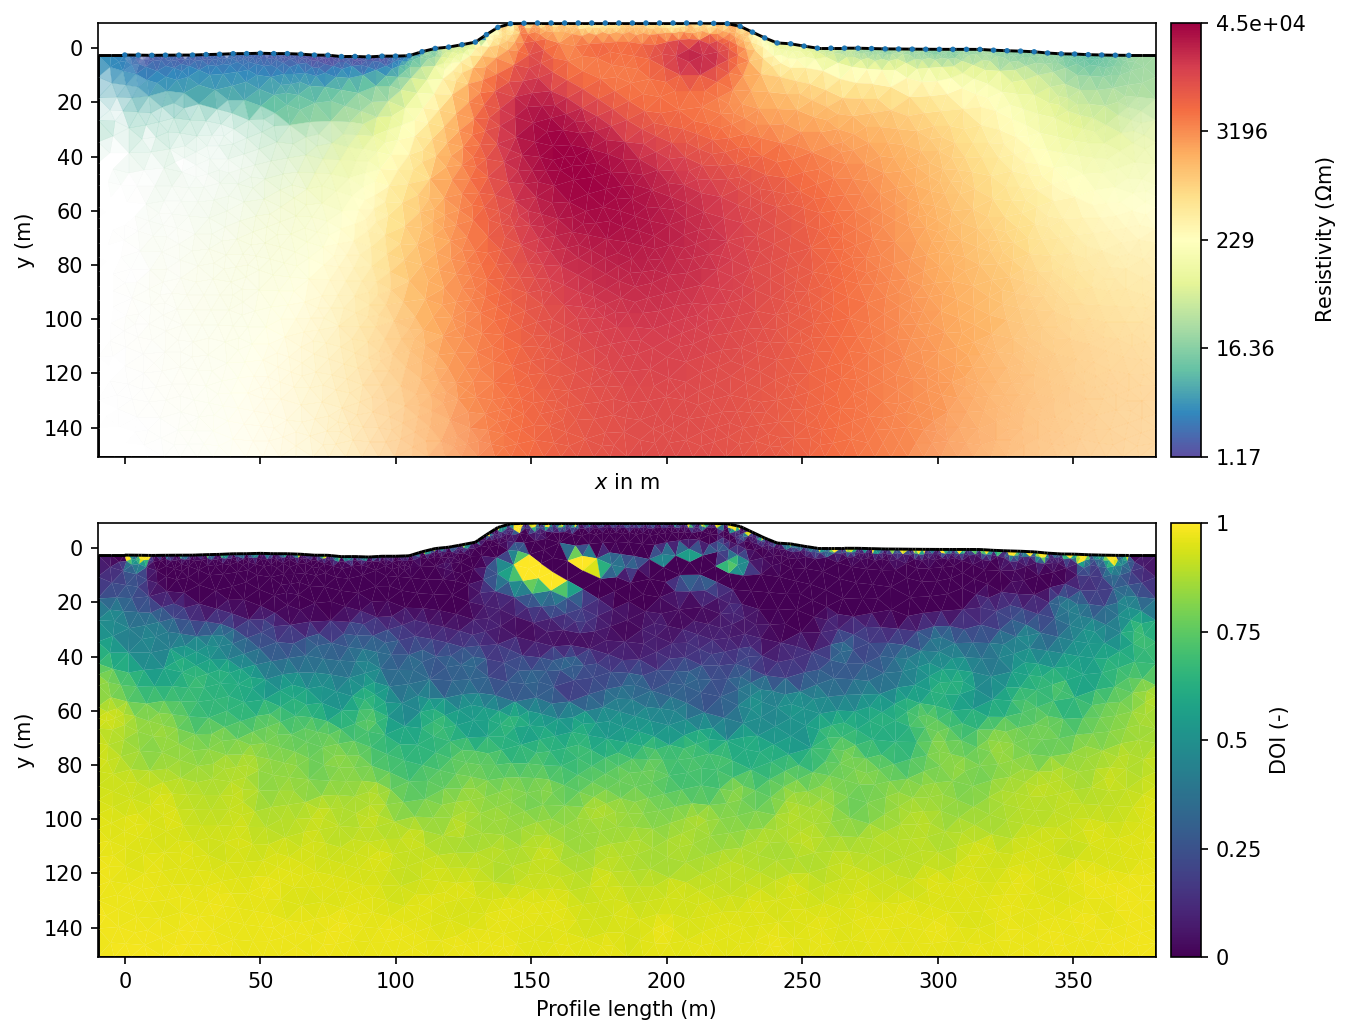

In [7]:
inv = mgr.invert(lam=20, verbose=True, paraDX=0.25, paraDZ=0.25, paraMaxCellSize=25)
def run_inv(referencemodel):
    # Set reference model as startmodel
    mgr.inv.inv.setModel(referencemodel)

    # Set reference model
    rm = mgr.inv.fop.regionManager()
    rm.setConstraintType(10) # 0 = reference model, 1 = first-order smoothing (default), 10 = both
    rm.fillConstraints(mgr.inv.fop.constraints())
    mgr.inv.inv.setReferenceModel(referencemodel)
    model = mgr.inv.inv.run()
    return model

def compute_DOI(ref1, ref2):
    m1 = run_inv(ref1)
    m2 = run_inv(ref2)

    R = (m1 - m2) / (m1r - m2r)
    return R


m1r = np.ones(mgr.paraDomain.cellCount()) * 100
m2r = np.ones(mgr.paraDomain.cellCount()) * 10000

DOI = compute_DOI(m1r, m2r)

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(10,7), dpi=150, sharex=True)

mgr.showResult(ax=ax1, orientation="vertical")
#ax1.set_xlabel("Profile length")
ax1.set_ylabel("y (m)")
pg.show(mgr.paraDomain, DOI, ax=ax2, cMin=0, cMax=1, orientation="vertical", label="DOI (-)")
ax2.set_xlabel("Profile length (m)")
ax2.set_ylabel("y (m)")


C:\Users\mealiy001\AppData\Local\Temp\ipykernel_36740\3554076232.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])


Text(109.08333333333333, 0.5, 'Relative Elevation (m)')

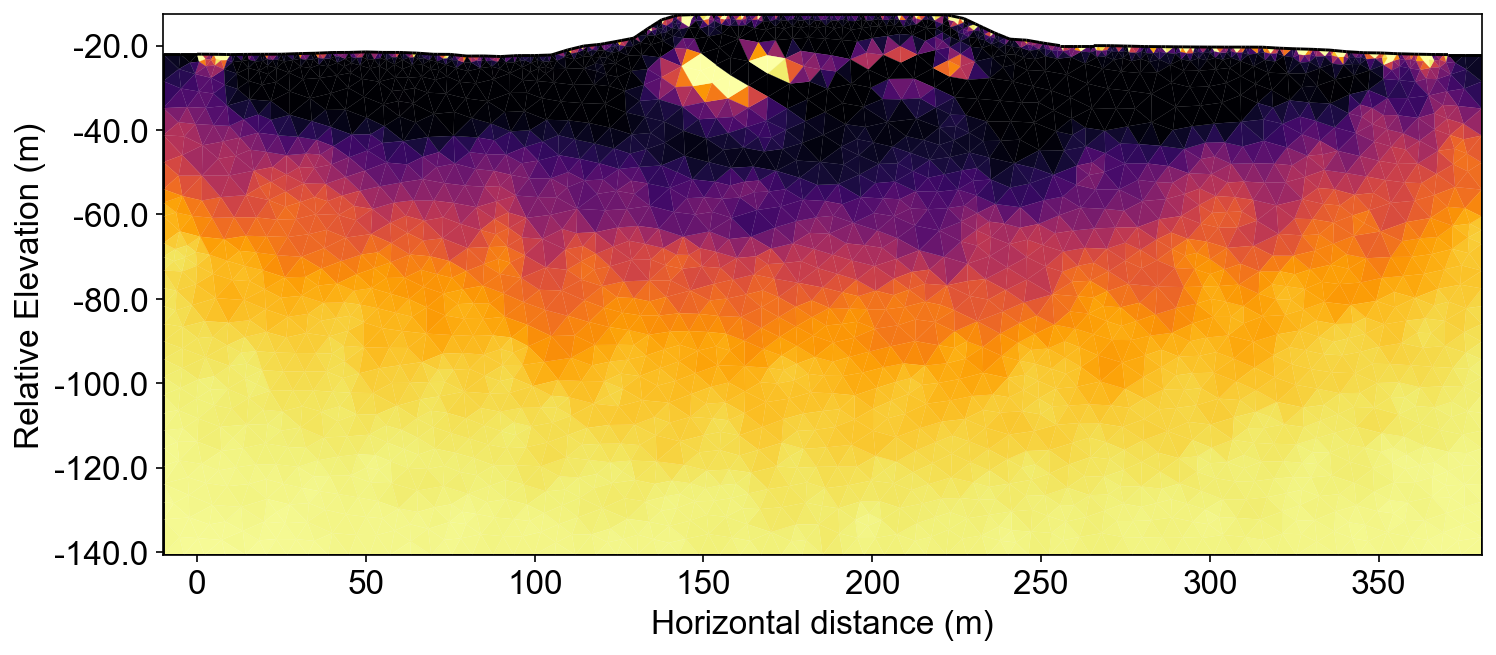

In [16]:
fig, (ax) = plt.subplots(1, 1, figsize=(10,5), dpi=150, sharex=True)
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'Arial'
mgr.showResult(ax=ax1, orientation="vertical")
#ax1.set_xlabel("Profile length")
#ax1.set_ylabel("y (m)")
pg.show(mgr.paraDomain, DOI, ax=ax, cMin=0, cMax=1, orientation="vertical", label="DOI", cMap='inferno', colorBar=False)
ax.set_xlabel("Horizontal distance (m)")
ax.set_ylabel("y (m)")
current_ticks = ax.get_yticks()
relative_ticks = current_ticks   # Assuming 17 is the minimum elevation

# Set the new tick labels to show relative elevation

ax.set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])
ax.set_ylabel("Relative Elevation (m)", fontsize=16)

In [17]:
mesh = mgr.paraDomain
mesh["DOI"] = DOI


mesh.exportVTK(dir+'pygimli/all_inversions/east_amph_DOI.vtk')

Text(87.33333333333333, 0.5, 'y (m)')

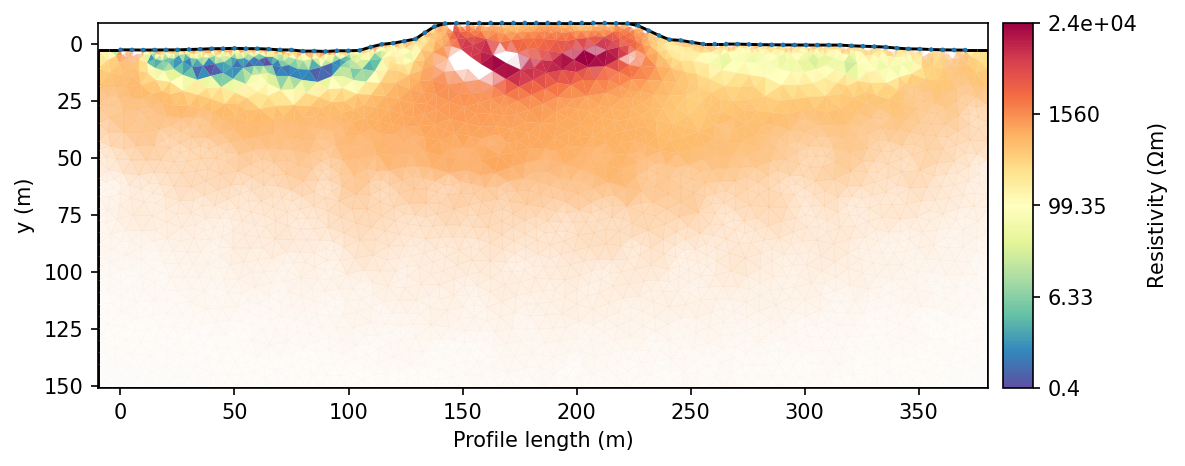

In [22]:
import numpy as np

def doi_to_transparency(doi, doiThreshold=0.2, maxDOI=1):
    """
    Convert DOI values into transparency values for visualization.

    Parameters:
        doi (array-like): DOI values.
        doiThreshold (float): DOI value below which transparency is 1 (fully opaque).
        maxDOI (float): DOI value at which transparency is 0 (fully transparent).

    Returns:
        array-like: Transparency values (1 = opaque, 0 = fully transparent).
    """
    D = np.asarray(doi)
    
    # Initialize alpha (transparency) array
    alpha = np.ones_like(D)  # Default to fully opaque

    # Apply gradual transparency beyond the DOI threshold
    mask = D > doiThreshold
    alpha[mask] = 1.0 - (D[mask] - doiThreshold) / (maxDOI - doiThreshold)

    # Cap values to ensure transparency is within [0,1]
    alpha = np.clip(alpha, 0, 1)
    
    return alpha



#opacity = np.ones(mgr.paraDomain.cellCount())
#opacity[DOI > 0.2] = 0
opacity = doi_to_transparency(DOI)
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
mgr.showResult(ax=ax, coverage=opacity, orientation = "vertical")
#ax.set_title("Inverse model with cutoff")
ax.set_xlabel("Profile length (m)")
ax.set_ylabel("y (m)")

Text(87.33333333333333, 0.5, 'y (m)')

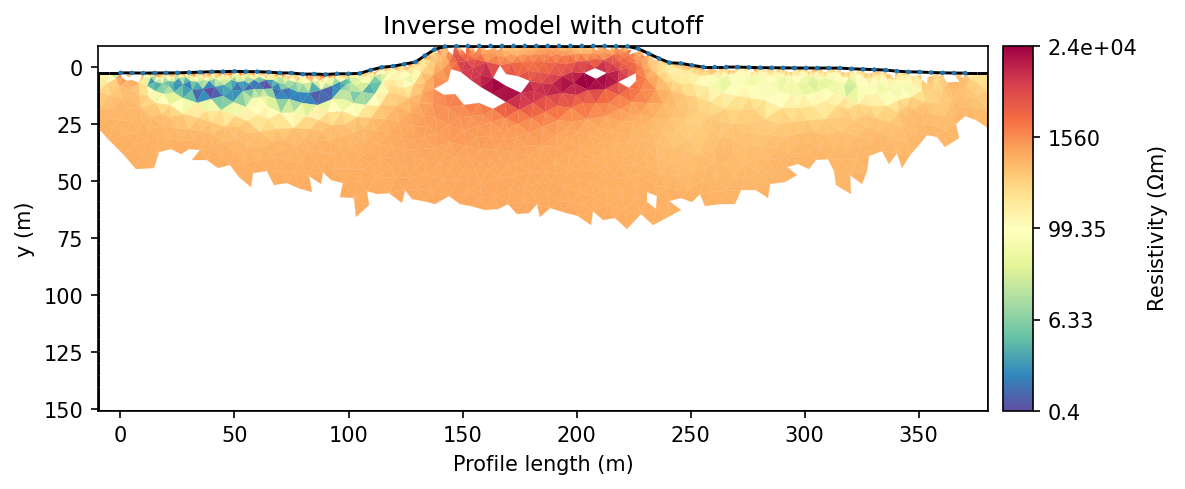

In [21]:
opacity = np.ones(mgr.paraDomain.cellCount())
opacity[DOI > 0.5] = 0
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
mgr.showResult(ax=ax, coverage=opacity, orientation = "vertical")
ax.set_title("Inverse model with cutoff")
ax.set_xlabel("Profile length (m)")
ax.set_ylabel("y (m)")

0 -10.0 -2.524 0.0
1 -10.0 -150.85846355054932 0.0
2 380.5167860041571 -150.85846355054932 0.0
3 380.5167860041571 -2.6517491488864673 0.0
4 -1492.0671440166284 -2.524 0.0
5 -1492.0671440166284 -1632.797858418291 0.0
6 1862.5839300207854 -2.6517491488864673 0.0
7 1862.5839300207854 -1632.9256075671776 0.0
8 0.0 -2.524 0.0
9 1.2499516028108906 -2.5349995741047358 0.0
10 3.749854808432672 -2.5569987223142077 0.0
11 4.999806411243562 -2.5679982964189434 0.0
12 6.249658216467371 -2.587245694797942 0.0
13 8.749361826914988 -2.625740491555939 0.0
14 9.999213632138797 -2.6449878899349377 0.0
15 11.249135228533955 -2.630993997401589 0.0
16 13.74897842132427 -2.603006212334891 0.0
17 14.998900017719428 -2.5890123198015424 0.0
18 16.24887898062829 -2.581760956840592 0.0
19 18.748836906446023 -2.567258230918692 0.0
20 19.998815869354885 -2.5600068679577417 0.0
21 21.24880946594051 -2.556006118763748 0.0
22 23.74879665911176 -2.548004620375762 0.0
23 24.998790255697386 -2.5440038711817685 0.0
24 2

(-30.0, 381.0)

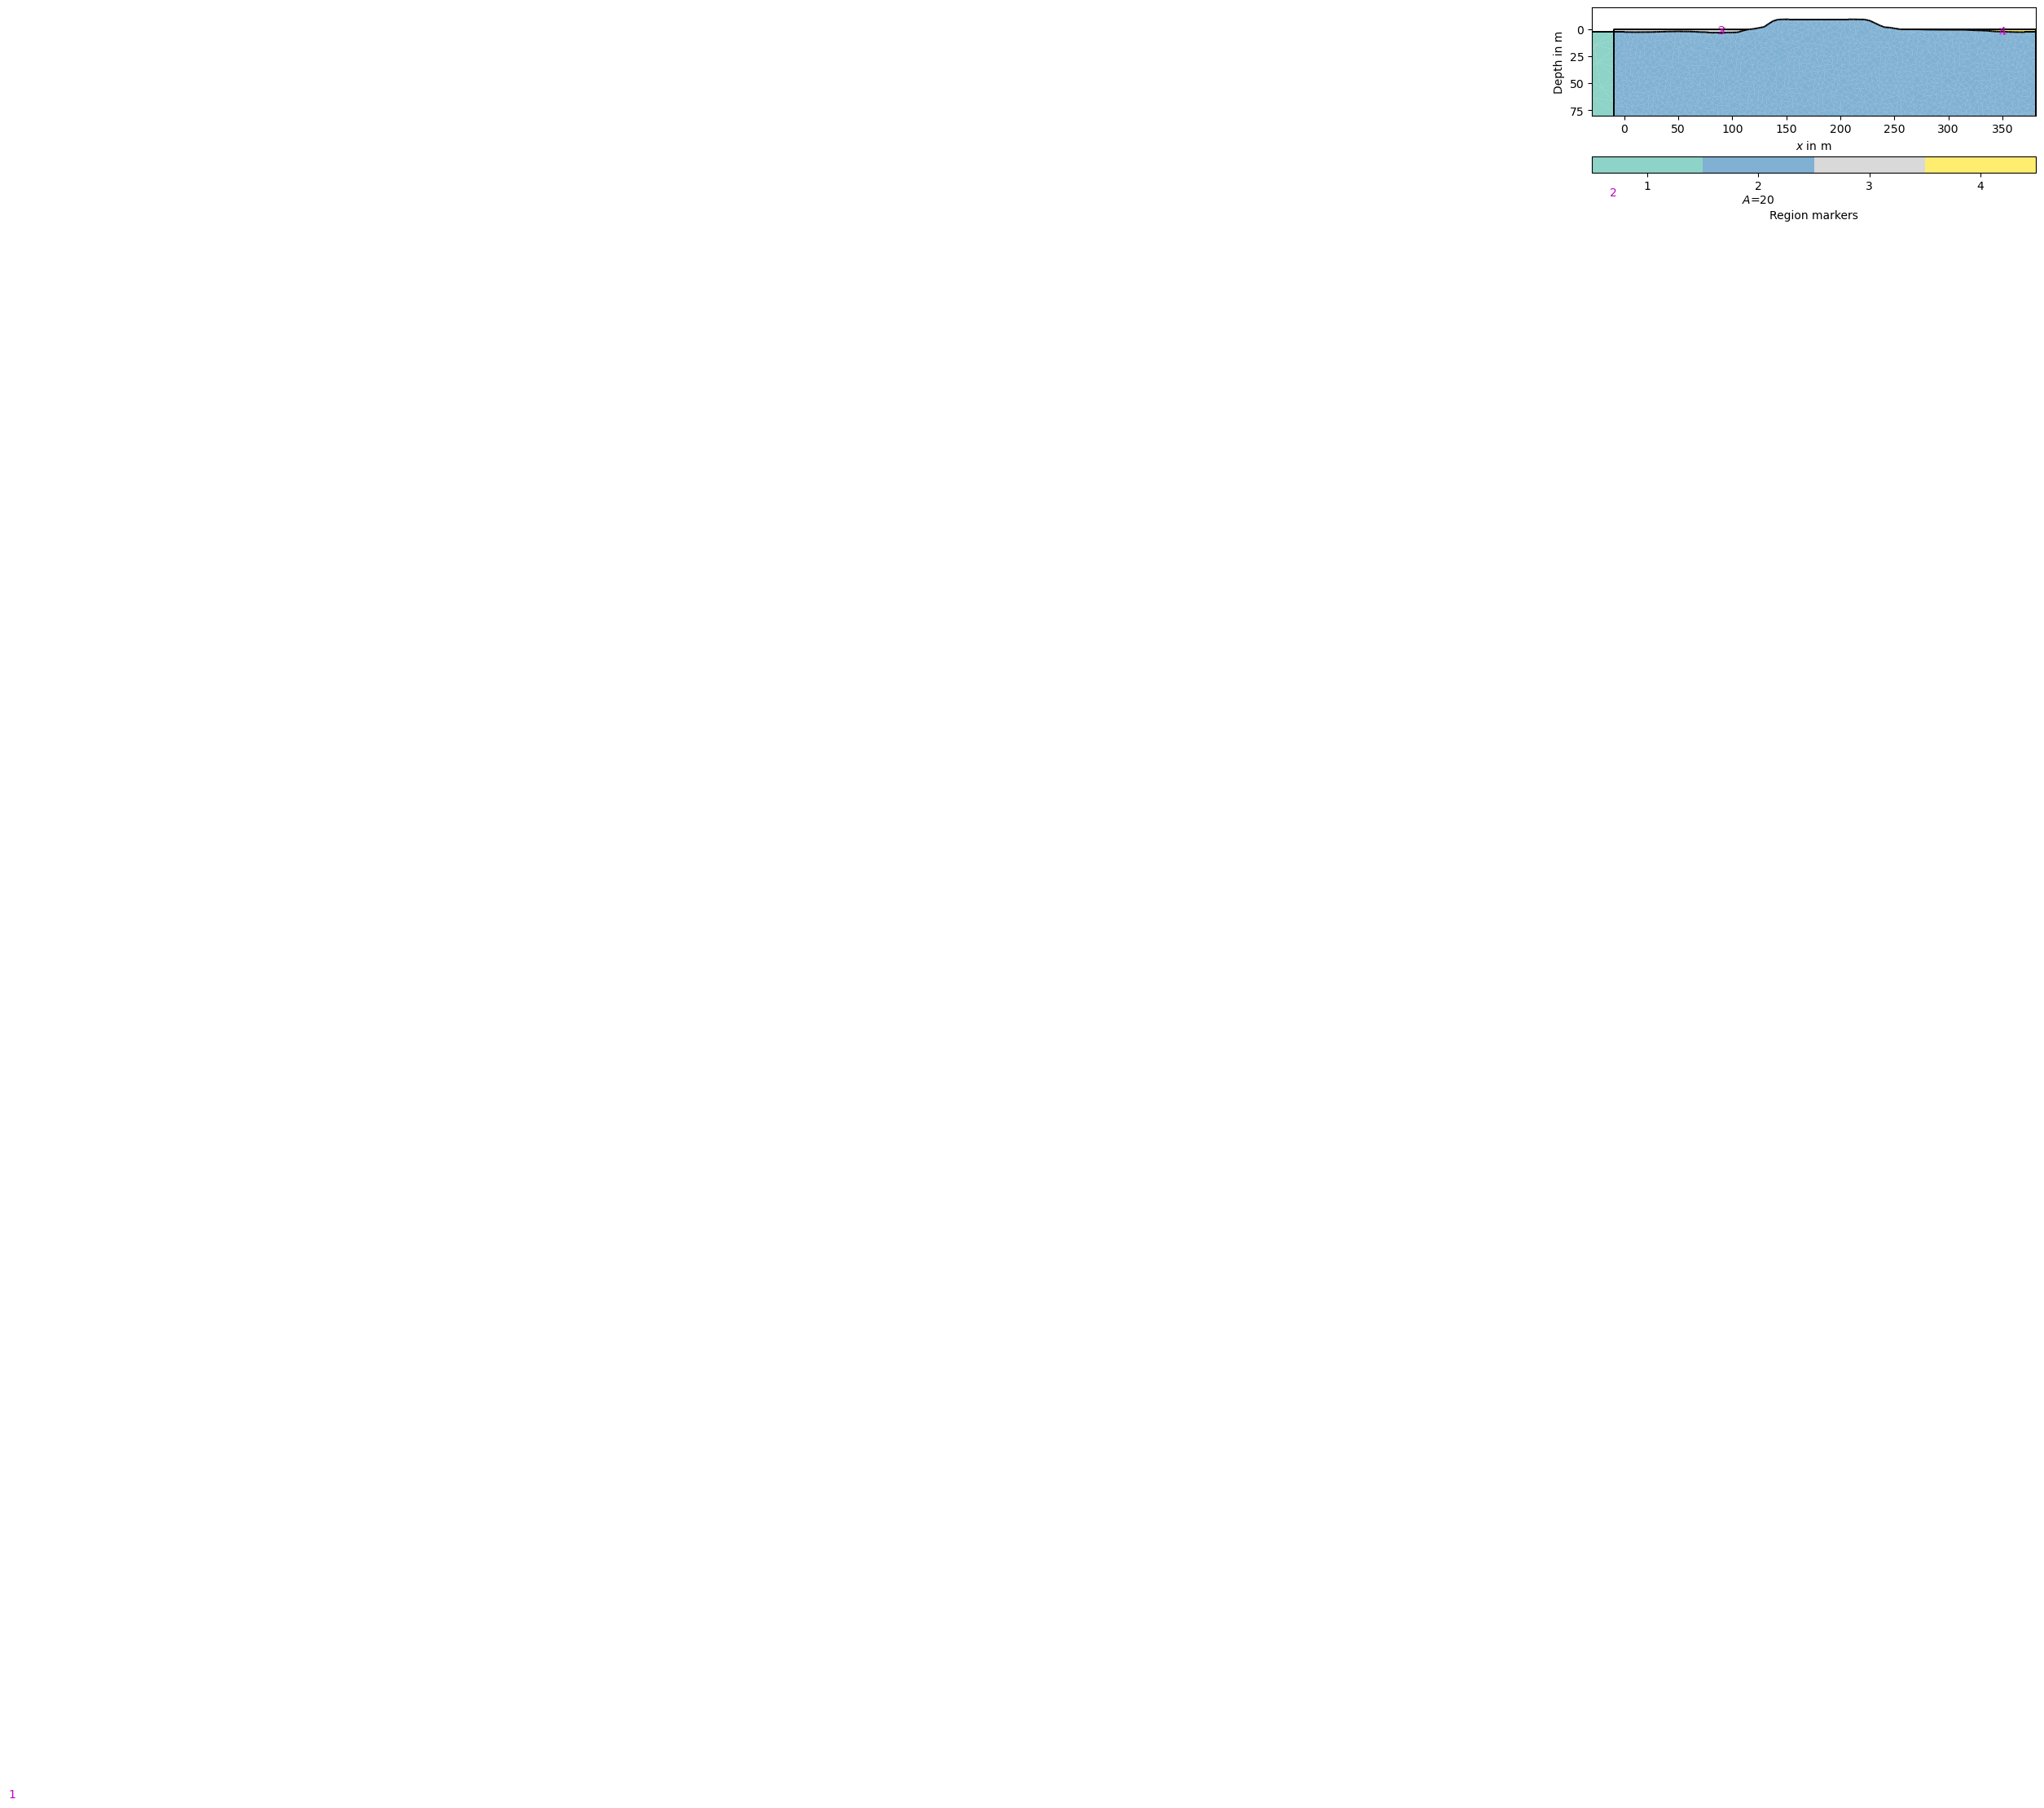

In [32]:
plc = mt.createParaMeshPLC(data,paraDX = 0.25, paraDZ= 0.25, paraMaxCellSize=20)
for i, n in enumerate(plc.nodes()[:]):
    #ax.text(n.x(), n.y(), str(i))
    print(i, n.x(), n.y(), n.z())
for nr, marker in enumerate(plc.regionMarkers()):
    print('Position marker number {}:'.format(nr + 1), marker.x(), marker.y(),
          marker.z())


plc.createNode(-10, 0, 0, marker=234)
#plc.createNode(113.5, 0, 0, marker=235)

plc.createNode(380.5167860041571, 0, 0, marker=235)

plc.createEdge(plc.node(234), plc.node(77), marker=-1)
plc.createEdge(plc.node(234), plc.node(0), marker=-1)
plc.createEdge(plc.node(164), plc.node(235), marker=-1)
plc.createEdge(plc.node(235), plc.node(3), marker=-1)

plc.addRegionMarker([90, -1], marker=3)  
plc.addRegionMarker([350, -1.5], marker=4)  


ax, _ = pg.show(plc)
ax.set_ylim(-80, 20)
ax.set_xlim(-30,381)


(-130.0, 381.0)

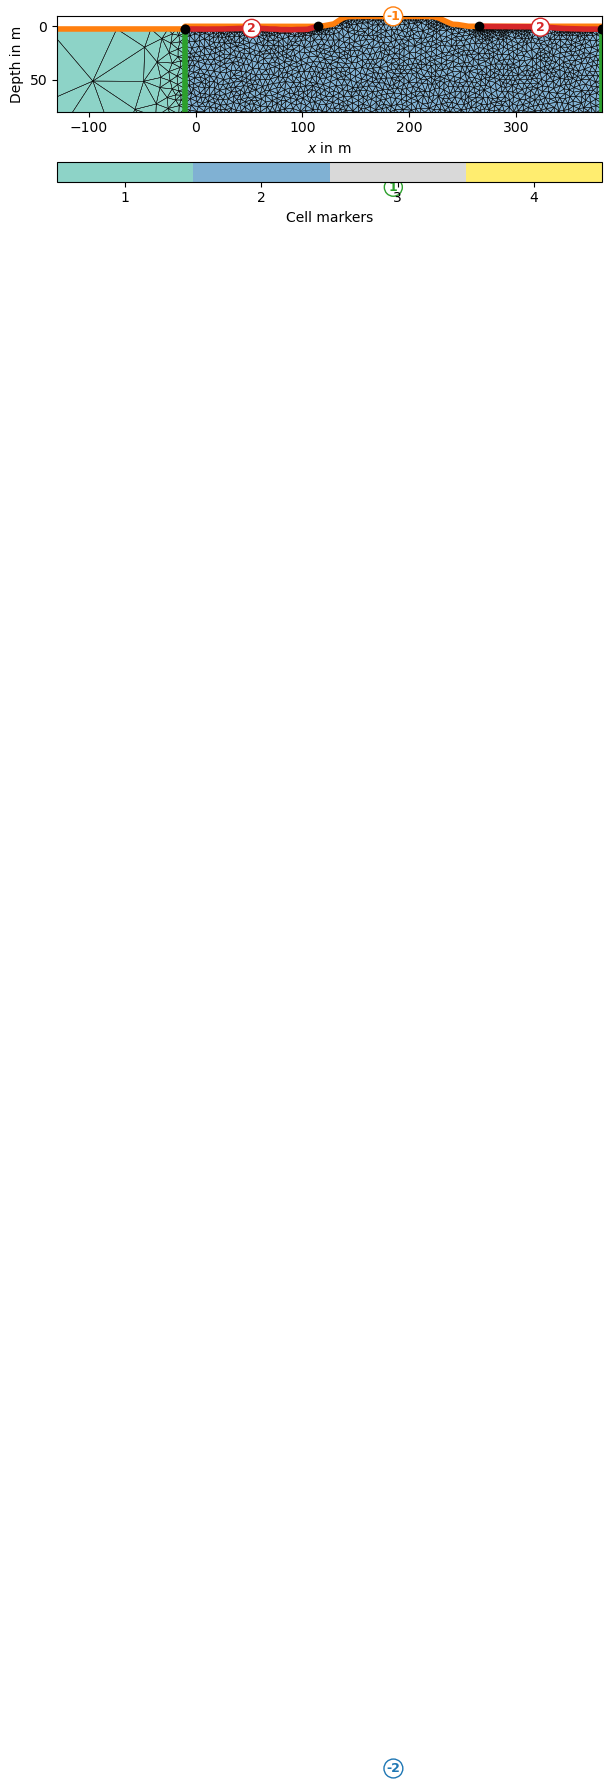

In [33]:
mesh = mt.createMesh(plc, quality=32)
for b in mesh.boundaries():
    if b.marker() == -1 and not b.outside():
        b.setMarker(2)

#print(mesh)
ax, _ = pg.show(mesh, markers=True, showMesh=True)
ax.set_ylim(-80)
ax.set_xlim(-130,381)

In [34]:
data
data['k_new'] = ert.createGeometricFactors(data, mesh=mesh, numerical=True)
data['rhoa'] = (data['r'])*data['k_new']

12/11/25 - 17:34:50 - pyGIMLi - INFO - Save RVector binary
12/11/25 - 17:34:50 - pyGIMLi - INFO - Cache stored: C:\Users\mealiy001\AppData\Roaming\pygimli\Cache\10427031686323587095


13/10/25 - 16:36:06 - pyGIMLi - INFO - Found 4 regions.
13/10/25 - 16:36:06 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
13/10/25 - 16:36:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
13/10/25 - 16:36:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
13/10/25 - 16:36:07 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 24845 Cells: 49104 Boundaries: 37120
13/10/25 - 16:36:08 - pyGIMLi - INFO - Use median(data values)=582.1116842026514
13/10/25 - 16:36:08 - pyGIMLi - INFO - Created startmodel from forward operator:10906, min/max=582.111684/582.111684
13/10/25 - 16:36:08 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014829AB81D0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
	 1 Logarithmic LU transform, lower bound 1.0, upper bound 2.0
	 2 Logarithmic LU transform, lower bound 2.5, upper bound 5.0
min/max (data): 2.29/5707
min/max (error): 2%/6.84%
min/max (start model): 582/582
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 8562.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  779.45 (dPhi = 90.42%) lam: 1000.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  114.81 (dPhi = 81.79%) lam: 1000.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =   47.89 (dPhi = 40.81%) lam: 1000.0
---

13/10/25 - 17:04:03 - pyGIMLi - INFO - Use median(data values)=582.1116842026514
13/10/25 - 17:04:03 - pyGIMLi - INFO - Created startmodel from forward operator:10906, min/max=582.111684/582.111684
13/10/25 - 17:04:03 - pyGIMLi - INFO - Starting inversion.


chi² =   40.07 (dPhi = 1.76%) lam: 1000.0
################################################################################
#                Abort criterion reached: dPhi = 1.76 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014829AB81D0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
	 1 Logarithmic LU transform, lower bound 1.0, upper bound 2.0
	 2 Logarithmic LU transform, lower bound 2.5, upper bound 5.0
min/max (data): 2.29/5707
min/max (error): 2%/6.84%
min/max (start model): 582/582
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 8562.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  799.41 (dPhi = 90.24%) lam: 784

13/10/25 - 17:35:38 - pyGIMLi - INFO - Use median(data values)=582.1116842026514
13/10/25 - 17:35:38 - pyGIMLi - INFO - Created startmodel from forward operator:10906, min/max=582.111684/582.111684
13/10/25 - 17:35:38 - pyGIMLi - INFO - Starting inversion.


chi² =   36.06 (dPhi = 0.60%) lam: 784.8
################################################################################
#                 Abort criterion reached: dPhi = 0.6 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014829AB81D0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
	 1 Logarithmic LU transform, lower bound 1.0, upper bound 2.0
	 2 Logarithmic LU transform, lower bound 2.5, upper bound 5.0
min/max (data): 2.29/5707
min/max (error): 2%/6.84%
min/max (start model): 582/582
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 8562.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  819.55 (dPhi = 90.05%) lam: 615.

13/10/25 - 18:08:07 - pyGIMLi - INFO - Use median(data values)=582.1116842026514
13/10/25 - 18:08:07 - pyGIMLi - INFO - Created startmodel from forward operator:10906, min/max=582.111684/582.111684
13/10/25 - 18:08:07 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014829AB81D0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
	 1 Logarithmic LU transform, lower bound 1.0, upper bound 2.0
	 2 Logarithmic LU transform, lower bound 2.5, upper bound 5.0
min/max (data): 2.29/5707
min/max (error): 2%/6.84%
min/max (start model): 582/582
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 8562.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  837.83 (dPhi = 89.88%) lam: 483.3
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  111.77 (dPhi = 84.64%) lam: 483.3
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =   47.29 (dPhi = 45.89%) lam: 483.3
------

13/10/25 - 18:41:09 - pyGIMLi - INFO - Use median(data values)=582.1116842026514
13/10/25 - 18:41:09 - pyGIMLi - INFO - Created startmodel from forward operator:10906, min/max=582.111684/582.111684
13/10/25 - 18:41:09 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014829AB81D0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
	 1 Logarithmic LU transform, lower bound 1.0, upper bound 2.0
	 2 Logarithmic LU transform, lower bound 2.5, upper bound 5.0
min/max (data): 2.29/5707
min/max (error): 2%/6.84%
min/max (start model): 582/582
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 8562.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  859.50 (dPhi = 89.66%) lam: 379.3
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  116.76 (dPhi = 84.79%) lam: 379.3
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =   48.74 (dPhi = 48.12%) lam: 379.3
------

13/10/25 - 19:17:52 - pyGIMLi - INFO - Use median(data values)=582.1116842026514
13/10/25 - 19:17:52 - pyGIMLi - INFO - Created startmodel from forward operator:10906, min/max=582.111684/582.111684
13/10/25 - 19:17:52 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014829AB81D0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
	 1 Logarithmic LU transform, lower bound 1.0, upper bound 2.0
	 2 Logarithmic LU transform, lower bound 2.5, upper bound 5.0
min/max (data): 2.29/5707
min/max (error): 2%/6.84%
min/max (start model): 582/582
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 8562.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  882.27 (dPhi = 89.42%) lam: 297.6
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  123.52 (dPhi = 84.69%) lam: 297.6
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =   52.26 (dPhi = 49.18%) lam: 297.6
------

13/10/25 - 19:55:02 - pyGIMLi - INFO - Use median(data values)=582.1116842026514
13/10/25 - 19:55:02 - pyGIMLi - INFO - Created startmodel from forward operator:10906, min/max=582.111684/582.111684
13/10/25 - 19:55:02 - pyGIMLi - INFO - Starting inversion.


chi² =   25.25 (dPhi = 0.31%) lam: 297.6
################################################################################
#                Abort criterion reached: dPhi = 0.31 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014829AB81D0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
	 1 Logarithmic LU transform, lower bound 1.0, upper bound 2.0
	 2 Logarithmic LU transform, lower bound 2.5, upper bound 5.0
min/max (data): 2.29/5707
min/max (error): 2%/6.84%
min/max (start model): 582/582
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 8562.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  905.02 (dPhi = 89.17%) lam: 233.

13/10/25 - 20:32:18 - pyGIMLi - INFO - Use median(data values)=582.1116842026514
13/10/25 - 20:32:18 - pyGIMLi - INFO - Created startmodel from forward operator:10906, min/max=582.111684/582.111684
13/10/25 - 20:32:18 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014829AB81D0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
	 1 Logarithmic LU transform, lower bound 1.0, upper bound 2.0
	 2 Logarithmic LU transform, lower bound 2.5, upper bound 5.0
min/max (data): 2.29/5707
min/max (error): 2%/6.84%
min/max (start model): 582/582
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 8562.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  940.29 (dPhi = 88.78%) lam: 183.3
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  144.29 (dPhi = 83.86%) lam: 183.3
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =   51.27 (dPhi = 58.08%) lam: 183.3
------

13/10/25 - 21:14:19 - pyGIMLi - INFO - Use median(data values)=582.1116842026514
13/10/25 - 21:14:19 - pyGIMLi - INFO - Created startmodel from forward operator:10906, min/max=582.111684/582.111684
13/10/25 - 21:14:19 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014829AB81D0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
	 1 Logarithmic LU transform, lower bound 1.0, upper bound 2.0
	 2 Logarithmic LU transform, lower bound 2.5, upper bound 5.0
min/max (data): 2.29/5707
min/max (error): 2%/6.84%
min/max (start model): 582/582
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 8562.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  984.15 (dPhi = 88.28%) lam: 143.8
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  169.03 (dPhi = 82.23%) lam: 143.8
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =   54.63 (dPhi = 62.70%) lam: 143.8
------

13/10/25 - 22:00:45 - pyGIMLi - INFO - Use median(data values)=582.1116842026514
13/10/25 - 22:00:45 - pyGIMLi - INFO - Created startmodel from forward operator:10906, min/max=582.111684/582.111684
13/10/25 - 22:00:45 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014829AB81D0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
	 1 Logarithmic LU transform, lower bound 1.0, upper bound 2.0
	 2 Logarithmic LU transform, lower bound 2.5, upper bound 5.0
min/max (data): 2.29/5707
min/max (error): 2%/6.84%
min/max (start model): 582/582
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 8562.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 1038.39 (dPhi = 87.67%) lam: 112.9
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  209.75 (dPhi = 79.41%) lam: 112.9
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =   71.38 (dPhi = 62.57%) lam: 112.9
------

13/10/25 - 22:47:25 - pyGIMLi - INFO - Use median(data values)=582.1116842026514
13/10/25 - 22:47:25 - pyGIMLi - INFO - Created startmodel from forward operator:10906, min/max=582.111684/582.111684
13/10/25 - 22:47:25 - pyGIMLi - INFO - Starting inversion.


chi² =   19.35 (dPhi = 0.93%) lam: 112.9
################################################################################
#                Abort criterion reached: dPhi = 0.93 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014829AB81D0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
	 1 Logarithmic LU transform, lower bound 1.0, upper bound 2.0
	 2 Logarithmic LU transform, lower bound 2.5, upper bound 5.0
min/max (data): 2.29/5707
min/max (error): 2%/6.84%
min/max (start model): 582/582
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 8562.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 1107.24 (dPhi = 86.88%) lam: 88.6

13/10/25 - 23:34:16 - pyGIMLi - INFO - Use median(data values)=582.1116842026514
13/10/25 - 23:34:16 - pyGIMLi - INFO - Created startmodel from forward operator:10906, min/max=582.111684/582.111684
13/10/25 - 23:34:16 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014829AB81D0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
	 1 Logarithmic LU transform, lower bound 1.0, upper bound 2.0
	 2 Logarithmic LU transform, lower bound 2.5, upper bound 5.0
min/max (data): 2.29/5707
min/max (error): 2%/6.84%
min/max (start model): 582/582
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 8562.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 1195.33 (dPhi = 85.87%) lam: 69.5
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  342.96 (dPhi = 71.19%) lam: 69.5
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =  103.16 (dPhi = 68.22%) lam: 69.5
---------

14/10/25 - 00:36:16 - pyGIMLi - INFO - Use median(data values)=582.1116842026514
14/10/25 - 00:36:16 - pyGIMLi - INFO - Created startmodel from forward operator:10906, min/max=582.111684/582.111684
14/10/25 - 00:36:16 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014829AB81D0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
	 1 Logarithmic LU transform, lower bound 1.0, upper bound 2.0
	 2 Logarithmic LU transform, lower bound 2.5, upper bound 5.0
min/max (data): 2.29/5707
min/max (error): 2%/6.84%
min/max (start model): 582/582
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 8562.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 1283.65 (dPhi = 84.86%) lam: 54.6
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  407.57 (dPhi = 68.19%) lam: 54.6
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =  121.77 (dPhi = 68.87%) lam: 54.6
---------

14/10/25 - 01:26:05 - pyGIMLi - INFO - Use median(data values)=582.1116842026514
14/10/25 - 01:26:05 - pyGIMLi - INFO - Created startmodel from forward operator:10906, min/max=582.111684/582.111684
14/10/25 - 01:26:05 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014829AB81D0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
	 1 Logarithmic LU transform, lower bound 1.0, upper bound 2.0
	 2 Logarithmic LU transform, lower bound 2.5, upper bound 5.0
min/max (data): 2.29/5707
min/max (error): 2%/6.84%
min/max (start model): 582/582
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 8562.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 1364.07 (dPhi = 83.94%) lam: 42.8
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  448.79 (dPhi = 67.05%) lam: 42.8
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =  135.12 (dPhi = 68.89%) lam: 42.8
---------

14/10/25 - 02:20:19 - pyGIMLi - INFO - Use median(data values)=582.1116842026514
14/10/25 - 02:20:19 - pyGIMLi - INFO - Created startmodel from forward operator:10906, min/max=582.111684/582.111684
14/10/25 - 02:20:19 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014829AB81D0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
	 1 Logarithmic LU transform, lower bound 1.0, upper bound 2.0
	 2 Logarithmic LU transform, lower bound 2.5, upper bound 5.0
min/max (data): 2.29/5707
min/max (error): 2%/6.84%
min/max (start model): 582/582
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 8562.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 1455.50 (dPhi = 82.89%) lam: 33.6
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  522.96 (dPhi = 64.04%) lam: 33.6
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =  141.90 (dPhi = 72.09%) lam: 33.6
---------

14/10/25 - 03:24:52 - pyGIMLi - INFO - Use median(data values)=582.1116842026514
14/10/25 - 03:24:52 - pyGIMLi - INFO - Created startmodel from forward operator:10906, min/max=582.111684/582.111684
14/10/25 - 03:24:52 - pyGIMLi - INFO - Starting inversion.


chi² =   15.75 (dPhi = 1.06%) lam: 33.6
################################################################################
#                Abort criterion reached: dPhi = 1.06 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014829AB81D0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
	 1 Logarithmic LU transform, lower bound 1.0, upper bound 2.0
	 2 Logarithmic LU transform, lower bound 2.5, upper bound 5.0
min/max (data): 2.29/5707
min/max (error): 2%/6.84%
min/max (start model): 582/582
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 8562.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 1549.74 (dPhi = 81.81%) lam: 26.4


14/10/25 - 04:29:16 - pyGIMLi - INFO - Use median(data values)=582.1116842026514
14/10/25 - 04:29:16 - pyGIMLi - INFO - Created startmodel from forward operator:10906, min/max=582.111684/582.111684
14/10/25 - 04:29:16 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014829AB81D0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
	 1 Logarithmic LU transform, lower bound 1.0, upper bound 2.0
	 2 Logarithmic LU transform, lower bound 2.5, upper bound 5.0
min/max (data): 2.29/5707
min/max (error): 2%/6.84%
min/max (start model): 582/582
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 8562.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 1641.51 (dPhi = 80.75%) lam: 20.7
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  629.02 (dPhi = 61.64%) lam: 20.7
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =  174.10 (dPhi = 71.82%) lam: 20.7
---------

14/10/25 - 05:29:23 - pyGIMLi - INFO - Use median(data values)=582.1116842026514
14/10/25 - 05:29:23 - pyGIMLi - INFO - Created startmodel from forward operator:10906, min/max=582.111684/582.111684
14/10/25 - 05:29:23 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014829AB81D0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
	 1 Logarithmic LU transform, lower bound 1.0, upper bound 2.0
	 2 Logarithmic LU transform, lower bound 2.5, upper bound 5.0
min/max (data): 2.29/5707
min/max (error): 2%/6.84%
min/max (start model): 582/582
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 8562.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 1723.89 (dPhi = 79.80%) lam: 16.2
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  745.29 (dPhi = 56.73%) lam: 16.2
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =  194.99 (dPhi = 73.46%) lam: 16.2
---------

14/10/25 - 06:34:05 - pyGIMLi - INFO - Use median(data values)=582.1116842026514
14/10/25 - 06:34:05 - pyGIMLi - INFO - Created startmodel from forward operator:10906, min/max=582.111684/582.111684
14/10/25 - 06:34:05 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014829AB81D0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
	 1 Logarithmic LU transform, lower bound 1.0, upper bound 2.0
	 2 Logarithmic LU transform, lower bound 2.5, upper bound 5.0
min/max (data): 2.29/5707
min/max (error): 2%/6.84%
min/max (start model): 582/582
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 8562.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 1788.88 (dPhi = 79.05%) lam: 12.7
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  648.18 (dPhi = 63.73%) lam: 12.7
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =  215.01 (dPhi = 66.43%) lam: 12.7
---------

14/10/25 - 07:40:25 - pyGIMLi - INFO - Use median(data values)=582.1116842026514
14/10/25 - 07:40:25 - pyGIMLi - INFO - Created startmodel from forward operator:10906, min/max=582.111684/582.111684
14/10/25 - 07:40:25 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014829AB81D0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
	 1 Logarithmic LU transform, lower bound 1.0, upper bound 2.0
	 2 Logarithmic LU transform, lower bound 2.5, upper bound 5.0
min/max (data): 2.29/5707
min/max (error): 2%/6.84%
min/max (start model): 582/582
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 8562.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 1846.86 (dPhi = 78.39%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  631.91 (dPhi = 65.75%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =  222.29 (dPhi = 64.44%) lam: 10.0
---------

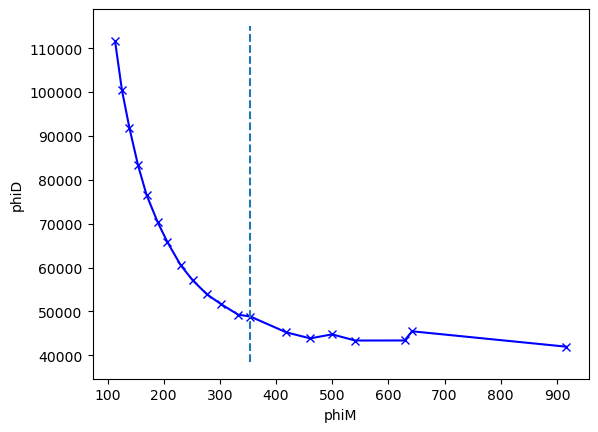

In [120]:
mgr.setMesh(mesh)


mgr.inv.setRegularization(3, limits=[1, 2], trans="log")
mgr.inv.setRegularization(4, limits=[2.5, 5], trans="log")
mgr.inv.setRegularization(2, zWeight=0.9)

lambdas = np.logspace(np.log10(1000), np.log10(10), num=20)
phiD = []
phiM = []
for lam in lambdas:
    mgr.invert(data, lam=lam, verbose=True)
    phiD.append(mgr.inv.phiData())
    phiM.append(mgr.inv.phiModel())

phiD = np.array(phiD)
phiM = np.array(phiM)

from kneed import DataGenerator, KneeLocator
kneedle = KneeLocator(phiM, phiD, online=True, curve="convex", direction="decreasing",interp_method='polynomial', polynomial_degree=3)

print(round(kneedle.elbow, 3))
print(round(kneedle.elbow_y, 3))
print(lambdas[np.where(phiM==kneedle.elbow)[0]])

plt.xlabel('phiM')
plt.ylabel('phiD')
plt.plot(phiM, phiD, 'bx-')
plt.vlines(kneedle.elbow, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

276.951
53895.257
[112.88378917]


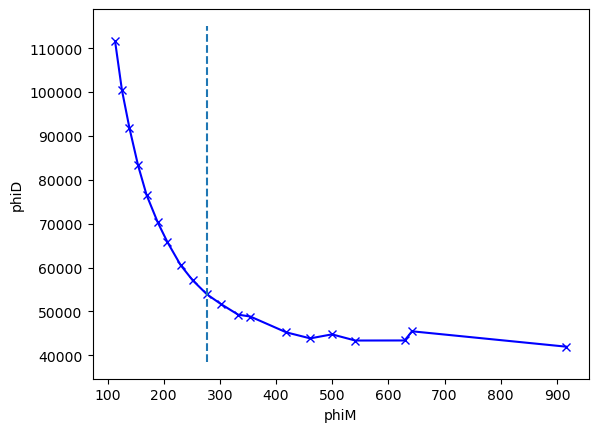

In [144]:
from kneed import DataGenerator, KneeLocator
kneedle = KneeLocator(phiM, phiD, online=True, curve="convex", direction="decreasing",interp_method='polynomial', polynomial_degree=5)

print(round(kneedle.elbow, 3))
print(round(kneedle.elbow_y, 3))
print(lambdas[np.where(phiM==kneedle.elbow)[0]])

plt.xlabel('phiM')
plt.ylabel('phiD')
plt.plot(phiM, phiD, 'bx-')
plt.vlines(kneedle.elbow, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

Elbow (x): 276.951
Elbow (y): 53895.257


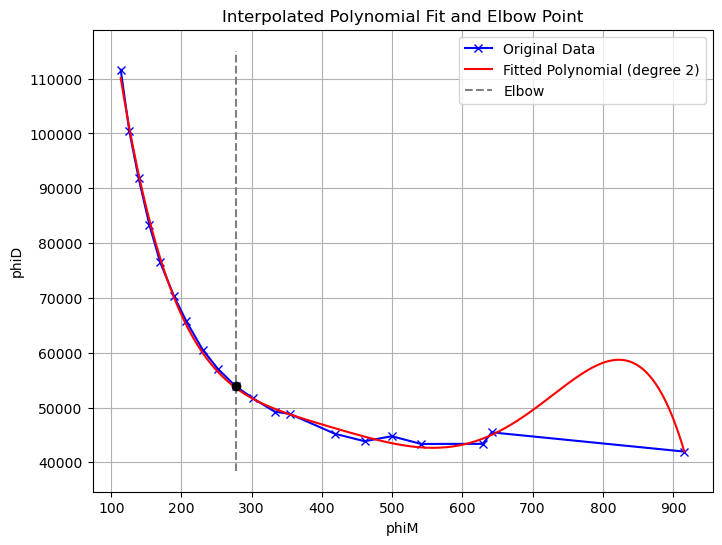

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator

kneedle = KneeLocator(
    phiM, phiD,
    online=True,
    curve="convex",
    direction="decreasing",
    interp_method='polynomial',
    polynomial_degree=5
)

# --- Print knee location ---
print("Elbow (x):", round(kneedle.elbow, 3))
print("Elbow (y):", round(kneedle.elbow_y, 3))

# --- Recreate the interpolated polynomial fit manually ---
degree = 5  # same as polynomial_degree
coeffs = np.polyfit(phiM, phiD, degree)
poly = np.poly1d(coeffs)

# Generate smooth fitted curve
phiM_fit = np.linspace(min(phiM), max(phiM), 1000)
phiD_fit = poly(phiM_fit)

# --- Plot ---
plt.figure(figsize=(8,6))
plt.plot(phiM, phiD, 'bx-', label='Original Data')
plt.plot(phiM_fit, phiD_fit, 'r-', label='Fitted Polynomial (degree 2)')
plt.vlines(kneedle.elbow, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color='gray', label='Elbow')
plt.scatter(kneedle.elbow, kneedle.elbow_y, color='black', zorder=5)

plt.xlabel('phiM')
plt.ylabel('phiD')
plt.legend()
plt.title('Interpolated Polynomial Fit and Elbow Point')
plt.grid(True)
plt.show()


301.622
51701.73
[88.58667904]


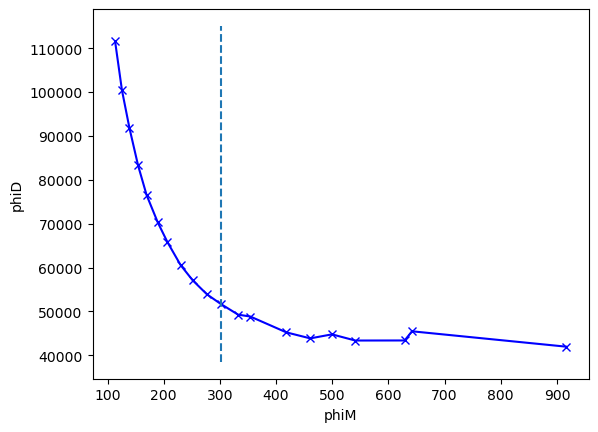

In [136]:
kneedle = KneeLocator(phiM, phiD, S=3.0, curve="convex", direction="decreasing",interp_method='interp1d')

print(round(kneedle.elbow, 3))
print(round(kneedle.knee_y, 3))
print(lambdas[np.where(phiM==kneedle.knee)[0]])

plt.xlabel('phiM')
plt.ylabel('phiD')
plt.plot(phiM, phiD, 'bx-')
plt.vlines(kneedle.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

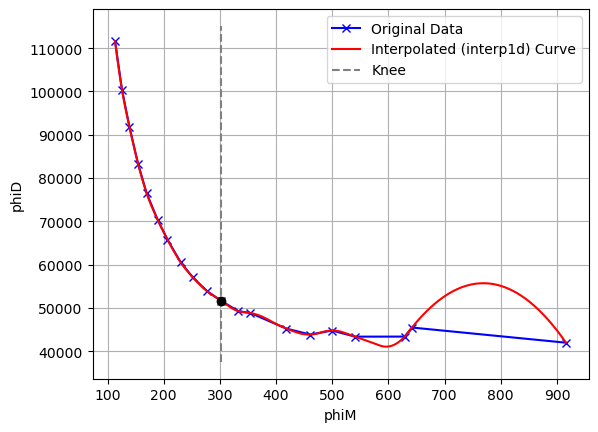

In [139]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

# Create the same interpolation that KneeLocator uses
f_interp = interp1d(phiM, phiD, kind='quadratic')  # or 'cubic', 'quadratic' if you want to test

phiM_fit = np.linspace(min(phiM), max(phiM), 200)
phiD_fit = f_interp(phiM_fit)

plt.plot(phiM, phiD, 'bx-', label='Original Data')
plt.plot(phiM_fit, phiD_fit, 'r-', label='Interpolated (interp1d) Curve')
plt.vlines(kneedle.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color='gray', label='Knee')
plt.scatter(kneedle.knee, kneedle.knee_y, color='black', zorder=5)
plt.xlabel('phiM')
plt.ylabel('phiD')
plt.legend()
plt.grid(True)
plt.show()

21/02/25 - 09:53:24 - pyGIMLi - INFO - Found 4 regions.
21/02/25 - 09:53:24 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
21/02/25 - 09:53:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
21/02/25 - 09:53:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
21/02/25 - 09:53:26 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 7183 Cells: 13800 Boundaries: 10632
21/02/25 - 09:53:27 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 09:53:27 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 09:53:27 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1EE0>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1E70>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C2B90>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   31.14 (dPhi = 89.30%) lam: 1000.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    9.25 (dPhi = 43.05%) lam: 1000.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    9.55 (dPhi = 4.46%) lam: 1000.0


21/02/25 - 10:00:45 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 10:00:45 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 10:00:45 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3370>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1AF0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C04A0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   30.66 (dPhi = 89.91%) lam: 799.9
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    8.24 (dPhi = 47.05%) lam: 799.9
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    8.17 (dPhi = 5.35%) lam: 799.9
---

21/02/25 - 10:08:58 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 10:08:58 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 10:08:58 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1AF0>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1B60>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C2340>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   30.96 (dPhi = 90.35%) lam: 639.9
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    7.51 (dPhi = 51.42%) lam: 639.9
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    7.01 (dPhi = 6.44%) lam: 639.9
---

21/02/25 - 10:18:12 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 10:18:12 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 10:18:12 - pyGIMLi - INFO - Starting inversion.


chi² =    6.68 (dPhi = 0.95%) lam: 639.9
################################################################################
#                Abort criterion reached: dPhi = 0.95 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3220>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C04A0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1540>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   31.06 (dPhi = 90.70%) lam: 

21/02/25 - 10:25:51 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 10:25:51 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 10:25:51 - pyGIMLi - INFO - Starting inversion.


chi² =    5.73 (dPhi = 1.19%) lam: 511.9
################################################################################
#                Abort criterion reached: dPhi = 1.19 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3220>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C04A0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1B60>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   31.44 (dPhi = 90.94%) lam: 

21/02/25 - 10:32:23 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 10:32:23 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 10:32:23 - pyGIMLi - INFO - Starting inversion.


chi² =    5.16 (dPhi = 10.49%) lam: 409.5
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    4.94 (dPhi = 1.42%) lam: 409.5
################################################################################
#                Abort criterion reached: dPhi = 1.42 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C04A0>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1B60>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1EE0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  4

21/02/25 - 10:39:22 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 10:39:22 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 10:39:22 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3220>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C04A0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1B60>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   32.96 (dPhi = 91.11%) lam: 262.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.59 (dPhi = 66.13%) lam: 262.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    3.89 (dPhi = 17.72%) lam: 262.0
--

21/02/25 - 10:47:05 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 10:47:05 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 10:47:05 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1B60>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1690>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1540>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   34.06 (dPhi = 91.07%) lam: 209.6
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.67 (dPhi = 68.98%) lam: 209.6
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    3.43 (dPhi = 22.45%) lam: 209.6
--

21/02/25 - 10:54:30 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 10:54:30 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 10:54:30 - pyGIMLi - INFO - Starting inversion.


chi² =    3.19 (dPhi = 0.50%) lam: 209.6
################################################################################
#                 Abort criterion reached: dPhi = 0.5 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1EE0>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1AF0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C2B90>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   35.58 (dPhi = 90.93%) lam: 

21/02/25 - 11:02:45 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 11:02:45 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 11:02:45 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1540>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1EE0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1AF0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   36.96 (dPhi = 90.76%) lam: 134.1
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.82 (dPhi = 73.96%) lam: 134.1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.81 (dPhi = 32.24%) lam: 134.1
--

21/02/25 - 11:09:09 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 11:09:09 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 11:09:09 - pyGIMLi - INFO - Starting inversion.


chi² =    2.65 (dPhi = 3.24%) lam: 134.1
--------------------------------------------------------------------------------
inv.iter 5 ... chi² =    2.54 (dPhi = 0.79%) lam: 134.1
################################################################################
#                Abort criterion reached: dPhi = 0.79 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1E70>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C2B90>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1690>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  44

21/02/25 - 11:15:51 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 11:15:51 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 11:15:51 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1B60>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C04A0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1E70>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   39.96 (dPhi = 90.31%) lam: 85.8
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.87 (dPhi = 77.80%) lam: 85.8
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.46 (dPhi = 41.11%) lam: 85.8
-----

21/02/25 - 11:24:29 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 11:24:29 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 11:24:29 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1AF0>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C2340>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C03C0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   41.57 (dPhi = 90.05%) lam: 68.7
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.71 (dPhi = 79.72%) lam: 68.7
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.33 (dPhi = 44.18%) lam: 68.7
-----

21/02/25 - 11:30:49 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 11:30:49 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 11:30:49 - pyGIMLi - INFO - Starting inversion.


chi² =    2.04 (dPhi = 6.21%) lam: 68.7
--------------------------------------------------------------------------------
inv.iter 5 ... chi² =    1.97 (dPhi = 1.40%) lam: 68.7
################################################################################
#                 Abort criterion reached: dPhi = 1.4 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3370>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x000002903A3747B0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x000002903A375BD0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.

21/02/25 - 11:37:26 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 11:37:26 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 11:37:26 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C04A0>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C03C0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1EE0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   44.31 (dPhi = 89.57%) lam: 43.9
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.51 (dPhi = 82.48%) lam: 43.9
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.22 (dPhi = 49.26%) lam: 43.9
-----

21/02/25 - 11:44:59 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 11:44:59 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 11:44:59 - pyGIMLi - INFO - Starting inversion.


chi² =    1.71 (dPhi = 1.80%) lam: 43.9
################################################################################
#                 Abort criterion reached: dPhi = 1.8 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3220>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3370>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x000002903A3747B0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   45.57 (dPhi = 89.34%) lam: 3

21/02/25 - 11:54:08 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 11:54:08 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 11:54:08 - pyGIMLi - INFO - Starting inversion.


chi² =    1.57 (dPhi = 0.67%) lam: 35.1
################################################################################
#                Abort criterion reached: dPhi = 0.67 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3220>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3370>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x000002903A3747B0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   46.68 (dPhi = 89.14%) lam: 2

21/02/25 - 12:04:11 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 12:04:11 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 12:04:11 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1AF0>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3220>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3370>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   47.74 (dPhi = 88.93%) lam: 22.5
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.28 (dPhi = 85.19%) lam: 22.5
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.23 (dPhi = 53.29%) lam: 22.5
-----

21/02/25 - 12:14:14 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 12:14:14 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 12:14:14 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3370>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1540>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1B60>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   48.83 (dPhi = 88.72%) lam: 18.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.31 (dPhi = 85.71%) lam: 18.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.25 (dPhi = 54.42%) lam: 18.0
-----

21/02/25 - 12:23:05 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 12:23:05 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 12:23:05 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1B60>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1EE0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C03C0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   50.01 (dPhi = 88.48%) lam: 14.4
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.60 (dPhi = 85.68%) lam: 14.4
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.34 (dPhi = 56.13%) lam: 14.4
-----

21/02/25 - 12:32:26 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 12:32:26 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 12:32:26 - pyGIMLi - INFO - Starting inversion.


chi² =    1.20 (dPhi = 0.19%) lam: 14.4
################################################################################
#                Abort criterion reached: dPhi = 0.19 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3220>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1E70>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x000002903A3747B0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   51.39 (dPhi = 88.19%) lam: 1

21/02/25 - 12:40:43 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 12:40:43 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 12:40:43 - pyGIMLi - INFO - Starting inversion.


chi² =    1.13 (dPhi = 0.32%) lam: 11.5
################################################################################
#                Abort criterion reached: dPhi = 0.32 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1E70>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C03C0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x000002903A3747B0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   53.13 (dPhi = 87.81%) lam: 9

21/02/25 - 12:50:10 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 12:50:10 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 12:50:10 - pyGIMLi - INFO - Starting inversion.


chi² =    1.07 (dPhi = 0.54%) lam: 9.2
################################################################################
#                Abort criterion reached: dPhi = 0.54 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C03C0>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C04A0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x000002903A375BD0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   55.22 (dPhi = 87.36%) lam: 7.

21/02/25 - 12:58:37 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 12:58:37 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 12:58:37 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1E70>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C03C0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C04A0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   57.71 (dPhi = 86.81%) lam: 5.9
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   10.46 (dPhi = 81.48%) lam: 5.9
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.54 (dPhi = 71.89%) lam: 5.9
--------

21/02/25 - 13:06:13 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 13:06:13 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 13:06:13 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3220>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C2B90>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1EE0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   60.70 (dPhi = 86.15%) lam: 4.7
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   12.65 (dPhi = 78.89%) lam: 4.7
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.76 (dPhi = 75.29%) lam: 4.7
--------

21/02/25 - 13:13:29 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 13:13:29 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 13:13:29 - pyGIMLi - INFO - Starting inversion.


chi² =    0.90 (dPhi = 17.74%) lam: 4.7


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.90)                   #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C2340>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1690>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x000002903A3747B0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   64.20 (dPhi = 85.37%) lam:

21/02/25 - 13:21:15 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 13:21:15 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 13:21:15 - pyGIMLi - INFO - Starting inversion.


chi² =    0.90 (dPhi = 7.12%) lam: 3.8


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.90)                   #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1690>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1B60>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x000002903A375BD0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   67.96 (dPhi = 84.54%) lam: 

21/02/25 - 13:29:24 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 13:29:24 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 13:29:24 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1540>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C2340>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1690>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   72.10 (dPhi = 83.62%) lam: 2.4
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   21.31 (dPhi = 70.38%) lam: 2.4
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    5.19 (dPhi = 74.47%) lam: 2.4
--------

21/02/25 - 13:40:00 - pyGIMLi - INFO - Use median(data values)=598.1559000395198


chi² =    0.91 (dPhi = 16.25%) lam: 2.4


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.91)                   #
################################################################################


21/02/25 - 13:40:00 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 13:40:00 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1E70>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1EE0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3220>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   76.37 (dPhi = 82.67%) lam: 1.9
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   23.97 (dPhi = 68.57%) lam: 1.9
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    6.51 (dPhi = 71.98%) lam: 1.9
--------

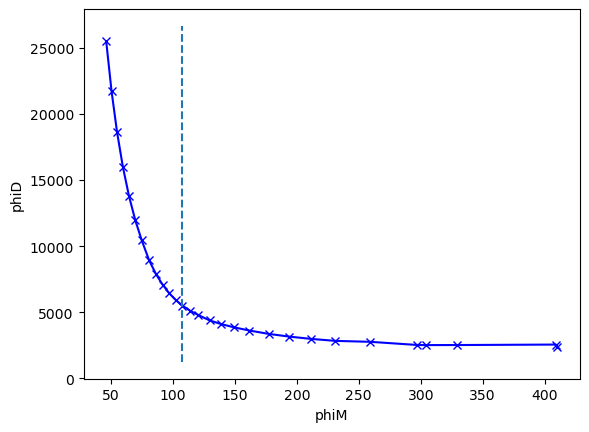

In [100]:
mgr.setMesh(mesh)


mgr.inv.setRegularization(3, limits=[1, 2], trans="log")
mgr.inv.setRegularization(4, limits=[2.5, 5], trans="log")
#mgr.inv.setRegularization(2, zWeight=0.9)

lambdas = np.logspace(np.log10(1000), np.log10(1.93), num=29)
phiD = []
phiM = []
for lam in lambdas:
    mgr.invert(data, lam=lam, verbose=True)
    phiD.append(mgr.inv.phiData())
    phiM.append(mgr.inv.phiModel())

phiD = np.array(phiD)
phiM = np.array(phiM)

from kneed import DataGenerator, KneeLocator
kneedle = KneeLocator(phiM, phiD, S=1.0, curve="convex", direction="decreasing",interp_method='interp1d')

print(round(kneedle.elbow, 3))
print(round(kneedle.knee_y, 3))
print(lambdas[np.where(phiM==kneedle.knee)[0]])

plt.xlabel('phiM')
plt.ylabel('phiD')
plt.plot(phiM, phiD, 'bx-')
plt.vlines(kneedle.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')


149.203
3853.577
[22.48772434]


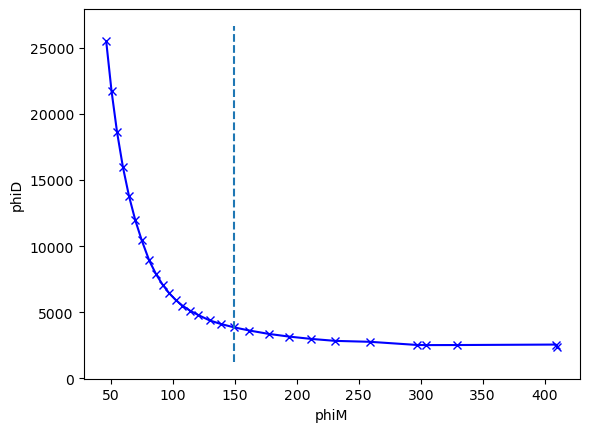

In [101]:
from kneed import DataGenerator, KneeLocator
kneedle = KneeLocator(phiM, phiD, online=True, curve="convex", direction="decreasing",interp_method='polynomial', polynomial_degree=3)

print(round(kneedle.elbow, 3))
print(round(kneedle.elbow_y, 3))
print(lambdas[np.where(phiM==kneedle.elbow)[0]])

plt.xlabel('phiM')
plt.ylabel('phiD')
plt.plot(phiM, phiD, 'bx-')
plt.vlines(kneedle.elbow, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')



13/11/25 - 09:43:09 - pyGIMLi - INFO - Saving inversion results to: //smb.isipd.dmawi.de/projects/p_subaqua/Expeditions/2023/NWT2023/analysis_Tuk/Tuk_all_mehriban/pygimli/all_inversions/INV_eastern_new_rhoa_updated\ERTManager


Path //smb.isipd.dmawi.de/projects/p_subaqua/Expeditions/2023/NWT2023/analysis_Tuk/Tuk_all_mehriban/pygimli/all_inversions/INV_eastern_new_rhoa_updated\ERTManager already exists. Skipping


('//smb.isipd.dmawi.de/projects/p_subaqua/Expeditions/2023/NWT2023/analysis_Tuk/Tuk_all_mehriban/pygimli/all_inversions/INV_eastern_new_rhoa_updated\\ERTManager',
 <Figure size 1600x1000 with 2 Axes>,
 <Axes: xlabel='$x$ in m', ylabel='Depth in m'>)

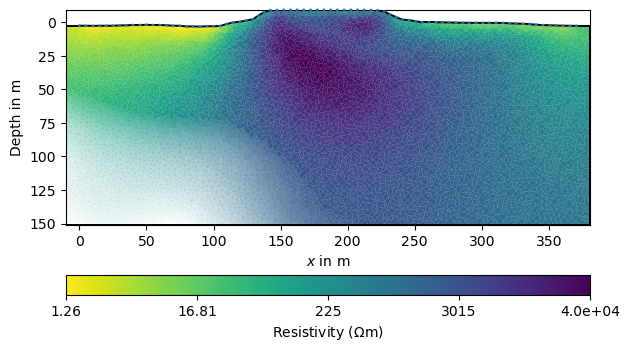

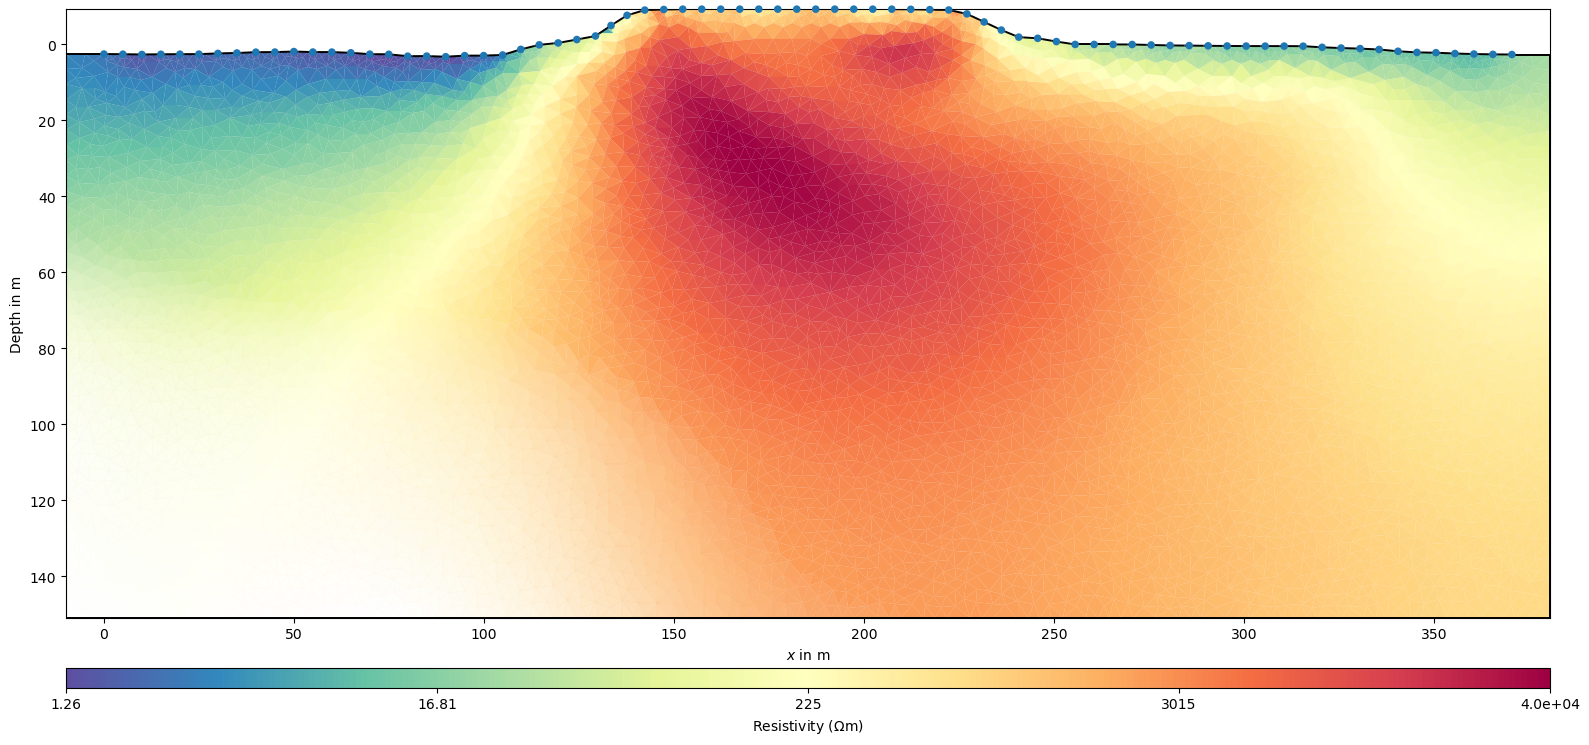

In [15]:
mgr.showResult(cMap="viridis_r", logScale=True)
mgr.saveResult(dir + 'pygimli/all_inversions/INV_eastern_new_rhoa_updated')

In [122]:
with open(dir+'processing/shoreline/joined_east.pkl', 'rb') as f:
    joined_east = pickle.load(f)

In [123]:
eastshore = joined_east[['year', 'xc', 'zc']].to_numpy()
eastshore[:, 1] = eastshore[:, 1].round(decimals=0)
eastshore[:, 2] = eastshore[:, 2].round(decimals=1)


In [124]:
posVec2 = [pg.Pos(pos) for pos in zip(eastshore[:, 1], eastshore[:, 2])]
para = pg.Mesh(mgr.paraDomain)
para.setCellMarkers(pg.IVector(para.cellCount()))




fopDP = PriorModelling(para, posVec2)


resMesh = fopDP(mgr.model)



cov = fopDP(mgr.coverage())

east_shoreline_plots = np.column_stack((eastshore[:, 1], eastshore[:, 2], resMesh, eastshore[:, 0], cov,))
east_shoreline_plots = np.c_[ east_shoreline_plots, 2023 - east_shoreline_plots[:, 3] ]
column_titles = "X,Y,ResMesh,Year,Cov,Age"
np.savetxt(
    dir+'processing/shoreline/east_shoreline_plots.csv', 
    east_shoreline_plots, 
    delimiter=',', 
    header=column_titles, 
    comments=''  # Removes the '#' added to the header line by default
)

21/02/25 - 23:23:07 - pyGIMLi - INFO - Found 1 regions.


In [48]:
np.logspace(1, 3, 20)

array([  10.        ,   12.74274986,   16.23776739,   20.69138081,
         26.36650899,   33.59818286,   42.81332399,   54.55594781,
         69.51927962,   88.58667904,  112.88378917,  143.84498883,
        183.29807108,  233.57214691,  297.63514416,  379.26901907,
        483.29302386,  615.84821107,  784.75997035, 1000.        ])

12/11/25 - 20:57:51 - pyGIMLi - INFO - Found 2 regions.
12/11/25 - 20:57:51 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
12/11/25 - 20:57:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
12/11/25 - 20:57:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
12/11/25 - 20:57:52 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 23657 Cells: 46776 Boundaries: 35350
12/11/25 - 20:57:52 - pyGIMLi - INFO - Use median(data values)=606.0093222631401
12/11/25 - 20:57:52 - pyGIMLi - INFO - Created startmodel from forward operator:10356, min/max=606.009322/606.009322
12/11/25 - 20:57:52 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001CBB017F290>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
min/max (data): 1.77/5564
min/max (error): 5%/9.84%
min/max (start model): 606/606
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1548.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  183.92 (dPhi = 88.03%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   85.04 (dPhi = 53.81%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =   21.35 (dPhi = 74.36%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    7.87 (dPhi = 61.48%) lam: 10.

12/11/25 - 21:08:17 - pyGIMLi - INFO - Use median(data values)=606.0093222631401
12/11/25 - 21:08:17 - pyGIMLi - INFO - Created startmodel from forward operator:10356, min/max=606.009322/606.009322
12/11/25 - 21:08:17 - pyGIMLi - INFO - Starting inversion.


chi² =    1.71 (dPhi = 1.19%) lam: 10.0
################################################################################
#                Abort criterion reached: dPhi = 1.19 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001CBB017F290>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
min/max (data): 1.77/5564
min/max (error): 5%/9.84%
min/max (start model): 606/606
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1548.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  169.40 (dPhi = 88.95%) lam: 12.7
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   85.95 (dPhi = 49.38%)

12/11/25 - 21:22:35 - pyGIMLi - INFO - Use median(data values)=606.0093222631401


chi² =    1.77 (dPhi = 1.19%) lam: 12.7
################################################################################
#                Abort criterion reached: dPhi = 1.19 (< 2.0%)                 #
################################################################################


12/11/25 - 21:22:35 - pyGIMLi - INFO - Created startmodel from forward operator:10356, min/max=606.009322/606.009322
12/11/25 - 21:22:35 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001CBB017F290>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
min/max (data): 1.77/5564
min/max (error): 5%/9.84%
min/max (start model): 606/606
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1548.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  153.59 (dPhi = 89.96%) lam: 16.2
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   73.83 (dPhi = 52.02%) lam: 16.2
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =   18.00 (dPhi = 74.77%) lam: 16.2
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    7.41 (dPhi = 56.35%) lam: 16.

12/11/25 - 21:34:37 - pyGIMLi - INFO - Use median(data values)=606.0093222631401
12/11/25 - 21:34:37 - pyGIMLi - INFO - Created startmodel from forward operator:10356, min/max=606.009322/606.009322


chi² =    1.88 (dPhi = 1.71%) lam: 16.2
################################################################################
#                Abort criterion reached: dPhi = 1.71 (< 2.0%)                 #
################################################################################


12/11/25 - 21:34:37 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001CBB017F290>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
min/max (data): 1.77/5564
min/max (error): 5%/9.84%
min/max (start model): 606/606
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1548.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  140.29 (dPhi = 90.80%) lam: 20.7
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   58.83 (dPhi = 58.07%) lam: 20.7
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =   15.75 (dPhi = 71.99%) lam: 20.7
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    7.38 (dPhi = 50.20%) lam: 20.

12/11/25 - 21:45:46 - pyGIMLi - INFO - Use median(data values)=606.0093222631401
12/11/25 - 21:45:46 - pyGIMLi - INFO - Created startmodel from forward operator:10356, min/max=606.009322/606.009322
12/11/25 - 21:45:46 - pyGIMLi - INFO - Starting inversion.


chi² =    1.98 (dPhi = 1.78%) lam: 20.7
################################################################################
#                Abort criterion reached: dPhi = 1.78 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001CBB017F290>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
min/max (data): 1.77/5564
min/max (error): 5%/9.84%
min/max (start model): 606/606
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1548.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  128.12 (dPhi = 91.57%) lam: 26.4
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   45.83 (dPhi = 64.07%)

12/11/25 - 22:00:23 - pyGIMLi - INFO - Use median(data values)=606.0093222631401
12/11/25 - 22:00:23 - pyGIMLi - INFO - Created startmodel from forward operator:10356, min/max=606.009322/606.009322
12/11/25 - 22:00:23 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001CBB017F290>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
min/max (data): 1.77/5564
min/max (error): 5%/9.84%
min/max (start model): 606/606
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1548.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  115.65 (dPhi = 92.36%) lam: 33.6
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   35.94 (dPhi = 68.57%) lam: 33.6
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    9.47 (dPhi = 70.94%) lam: 33.6
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    5.28 (dPhi = 38.57%) lam: 33.

12/11/25 - 22:13:29 - pyGIMLi - INFO - Use median(data values)=606.0093222631401
12/11/25 - 22:13:29 - pyGIMLi - INFO - Created startmodel from forward operator:10356, min/max=606.009322/606.009322
12/11/25 - 22:13:29 - pyGIMLi - INFO - Starting inversion.


chi² =    2.54 (dPhi = 1.67%) lam: 33.6
################################################################################
#                Abort criterion reached: dPhi = 1.67 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001CBB017F290>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
min/max (data): 1.77/5564
min/max (error): 5%/9.84%
min/max (start model): 606/606
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1548.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  106.39 (dPhi = 92.94%) lam: 42.8
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   28.31 (dPhi = 72.76%)

12/11/25 - 22:23:34 - pyGIMLi - INFO - Use median(data values)=606.0093222631401
12/11/25 - 22:23:34 - pyGIMLi - INFO - Created startmodel from forward operator:10356, min/max=606.009322/606.009322
12/11/25 - 22:23:34 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001CBB017F290>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
min/max (data): 1.77/5564
min/max (error): 5%/9.84%
min/max (start model): 606/606
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1548.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   98.13 (dPhi = 93.46%) lam: 54.6
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   22.01 (dPhi = 76.57%) lam: 54.6
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    5.34 (dPhi = 69.78%) lam: 54.6
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    3.34 (dPhi = 26.12%) lam: 54.

12/11/25 - 22:33:23 - pyGIMLi - INFO - Use median(data values)=606.0093222631401


chi² =    2.54 (dPhi = 1.35%) lam: 54.6
################################################################################
#                Abort criterion reached: dPhi = 1.35 (< 2.0%)                 #
################################################################################


12/11/25 - 22:33:23 - pyGIMLi - INFO - Created startmodel from forward operator:10356, min/max=606.009322/606.009322
12/11/25 - 22:33:23 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001CBB017F290>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
min/max (data): 1.77/5564
min/max (error): 5%/9.84%
min/max (start model): 606/606
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1548.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   92.84 (dPhi = 93.79%) lam: 69.5
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   18.50 (dPhi = 78.67%) lam: 69.5
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    4.37 (dPhi = 68.21%) lam: 69.5
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    3.16 (dPhi = 16.57%) lam: 69.

12/11/25 - 22:43:29 - pyGIMLi - INFO - Use median(data values)=606.0093222631401
12/11/25 - 22:43:29 - pyGIMLi - INFO - Created startmodel from forward operator:10356, min/max=606.009322/606.009322
12/11/25 - 22:43:29 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001CBB017F290>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
min/max (data): 1.77/5564
min/max (error): 5%/9.84%
min/max (start model): 606/606
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1548.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   88.79 (dPhi = 94.03%) lam: 88.6
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   15.56 (dPhi = 80.58%) lam: 88.6
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    4.01 (dPhi = 63.44%) lam: 88.6
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    3.15 (dPhi = 10.78%) lam: 88.

12/11/25 - 22:51:52 - pyGIMLi - INFO - Use median(data values)=606.0093222631401
12/11/25 - 22:51:52 - pyGIMLi - INFO - Created startmodel from forward operator:10356, min/max=606.009322/606.009322
12/11/25 - 22:51:52 - pyGIMLi - INFO - Starting inversion.


chi² =    2.91 (dPhi = 1.18%) lam: 88.6
################################################################################
#                Abort criterion reached: dPhi = 1.18 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001CBB017F290>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
min/max (data): 1.77/5564
min/max (error): 5%/9.84%
min/max (start model): 606/606
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1548.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   85.65 (dPhi = 94.21%) lam: 112.9
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   14.16 (dPhi = 81.05%

12/11/25 - 22:59:42 - pyGIMLi - INFO - Use median(data values)=606.0093222631401
12/11/25 - 22:59:42 - pyGIMLi - INFO - Created startmodel from forward operator:10356, min/max=606.009322/606.009322
12/11/25 - 22:59:42 - pyGIMLi - INFO - Starting inversion.


chi² =    3.16 (dPhi = 0.64%) lam: 112.9
################################################################################
#                Abort criterion reached: dPhi = 0.64 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001CBB017F290>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
min/max (data): 1.77/5564
min/max (error): 5%/9.84%
min/max (start model): 606/606
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1548.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   84.19 (dPhi = 94.28%) lam: 143.8
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   13.11 (dPhi = 81.43

12/11/25 - 23:08:01 - pyGIMLi - INFO - Use median(data values)=606.0093222631401
12/11/25 - 23:08:01 - pyGIMLi - INFO - Created startmodel from forward operator:10356, min/max=606.009322/606.009322
12/11/25 - 23:08:01 - pyGIMLi - INFO - Starting inversion.


chi² =    3.48 (dPhi = 0.72%) lam: 143.8
################################################################################
#                Abort criterion reached: dPhi = 0.72 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001CBB017F290>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
min/max (data): 1.77/5564
min/max (error): 5%/9.84%
min/max (start model): 606/606
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1548.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   81.93 (dPhi = 94.40%) lam: 183.3
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   12.36 (dPhi = 81.23

12/11/25 - 23:16:08 - pyGIMLi - INFO - Use median(data values)=606.0093222631401
12/11/25 - 23:16:08 - pyGIMLi - INFO - Created startmodel from forward operator:10356, min/max=606.009322/606.009322
12/11/25 - 23:16:08 - pyGIMLi - INFO - Starting inversion.


chi² =    3.84 (dPhi = 0.39%) lam: 183.3
################################################################################
#                Abort criterion reached: dPhi = 0.39 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001CBB017F290>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
min/max (data): 1.77/5564
min/max (error): 5%/9.84%
min/max (start model): 606/606
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1548.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   79.79 (dPhi = 94.49%) lam: 233.6
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   11.88 (dPhi = 80.64

12/11/25 - 23:22:56 - pyGIMLi - INFO - Use median(data values)=606.0093222631401
12/11/25 - 23:22:56 - pyGIMLi - INFO - Created startmodel from forward operator:10356, min/max=606.009322/606.009322
12/11/25 - 23:22:56 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001CBB017F290>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
min/max (data): 1.77/5564
min/max (error): 5%/9.84%
min/max (start model): 606/606
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1548.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   76.77 (dPhi = 94.63%) lam: 297.6
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   11.77 (dPhi = 79.19%) lam: 297.6
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    5.18 (dPhi = 35.10%) lam: 297.6
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    4.72 (dPhi = 3.15%) lam: 2

12/11/25 - 23:29:31 - pyGIMLi - INFO - Use median(data values)=606.0093222631401
12/11/25 - 23:29:31 - pyGIMLi - INFO - Created startmodel from forward operator:10356, min/max=606.009322/606.009322
12/11/25 - 23:29:31 - pyGIMLi - INFO - Starting inversion.


chi² =    4.64 (dPhi = 0.51%) lam: 297.6
################################################################################
#                Abort criterion reached: dPhi = 0.51 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001CBB017F290>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
min/max (data): 1.77/5564
min/max (error): 5%/9.84%
min/max (start model): 606/606
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1548.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   73.89 (dPhi = 94.75%) lam: 379.3
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   12.11 (dPhi = 76.95

12/11/25 - 23:36:19 - pyGIMLi - INFO - Use median(data values)=606.0093222631401
12/11/25 - 23:36:19 - pyGIMLi - INFO - Created startmodel from forward operator:10356, min/max=606.009322/606.009322
12/11/25 - 23:36:19 - pyGIMLi - INFO - Starting inversion.


chi² =    5.04 (dPhi = 0.40%) lam: 379.3
################################################################################
#                 Abort criterion reached: dPhi = 0.4 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001CBB017F290>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
min/max (data): 1.77/5564
min/max (error): 5%/9.84%
min/max (start model): 606/606
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1548.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   70.91 (dPhi = 94.86%) lam: 483.3
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   12.56 (dPhi = 74.16

12/11/25 - 23:43:06 - pyGIMLi - INFO - Use median(data values)=606.0093222631401
12/11/25 - 23:43:06 - pyGIMLi - INFO - Created startmodel from forward operator:10356, min/max=606.009322/606.009322
12/11/25 - 23:43:06 - pyGIMLi - INFO - Starting inversion.


chi² =    5.50 (dPhi = 0.36%) lam: 483.3
################################################################################
#                Abort criterion reached: dPhi = 0.36 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001CBB017F290>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
min/max (data): 1.77/5564
min/max (error): 5%/9.84%
min/max (start model): 606/606
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1548.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   68.03 (dPhi = 94.93%) lam: 615.8
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   13.23 (dPhi = 70.77

12/11/25 - 23:49:50 - pyGIMLi - INFO - Use median(data values)=606.0093222631401
12/11/25 - 23:49:50 - pyGIMLi - INFO - Created startmodel from forward operator:10356, min/max=606.009322/606.009322
12/11/25 - 23:49:50 - pyGIMLi - INFO - Starting inversion.


chi² =    6.04 (dPhi = 0.33%) lam: 615.8
################################################################################
#                Abort criterion reached: dPhi = 0.33 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001CBB017F290>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
min/max (data): 1.77/5564
min/max (error): 5%/9.84%
min/max (start model): 606/606
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1548.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   64.77 (dPhi = 95.01%) lam: 784.8
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   13.75 (dPhi = 66.83

12/11/25 - 23:56:36 - pyGIMLi - INFO - Use median(data values)=606.0093222631401
12/11/25 - 23:56:36 - pyGIMLi - INFO - Created startmodel from forward operator:10356, min/max=606.009322/606.009322
12/11/25 - 23:56:36 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001CBB017F290>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
min/max (data): 1.77/5564
min/max (error): 5%/9.84%
min/max (start model): 606/606
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1548.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   61.61 (dPhi = 95.06%) lam: 1000.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   14.24 (dPhi = 62.37%) lam: 1000.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    8.02 (dPhi = 17.50%) lam: 1000.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    7.63 (dPhi = 1.76%) lam

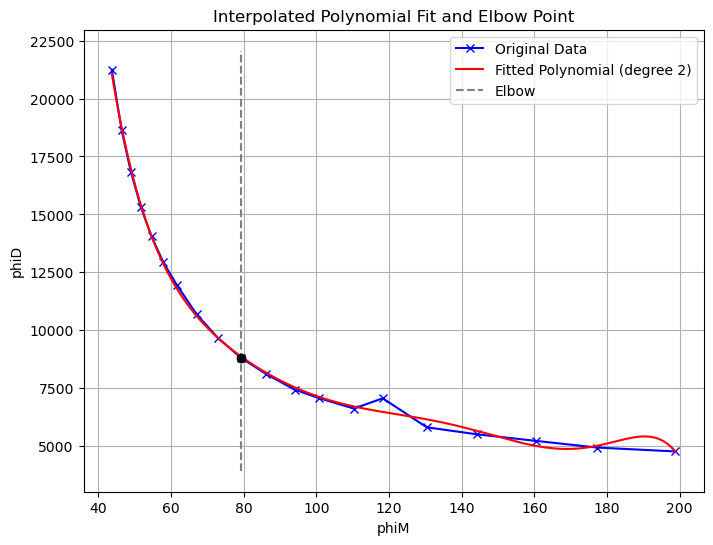

In [49]:
from kneed import KneeLocator

mgr.setMesh(mesh)



lambdas = np.logspace(1, 3, 20)
phiD = []
phiM = []
for lam in lambdas:
    mgr.invert(data, zWeight=0.5, lam=lam, verbose=True)
    phiD.append(mgr.inv.phiData())
    phiM.append(mgr.inv.phiModel())

phiD = np.array(phiD)
phiM = np.array(phiM)

kneedle = KneeLocator(
    phiM, phiD,
    online=True,
    curve="convex",
    direction="decreasing",
    interp_method='polynomial',
    polynomial_degree=7
)

# --- Print knee location ---
print("Elbow (x):", round(kneedle.elbow, 3))
print("Elbow (y):", round(kneedle.elbow_y, 3))

# --- Recreate the interpolated polynomial fit manually ---
degree = 7  # same as polynomial_degree
coeffs = np.polyfit(phiM, phiD, degree)
poly = np.poly1d(coeffs)

# Generate smooth fitted curve
phiM_fit = np.linspace(min(phiM), max(phiM), 1000)
phiD_fit = poly(phiM_fit)

# --- Plot ---
plt.figure(figsize=(8,6))
plt.plot(phiM, phiD, 'bx-', label='Original Data')
plt.plot(phiM_fit, phiD_fit, 'r-', label='Fitted Polynomial (degree 2)')
plt.vlines(kneedle.elbow, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color='gray', label='Elbow')
plt.scatter(kneedle.elbow, kneedle.elbow_y, color='black', zorder=5)

plt.xlabel('phiM')
plt.ylabel('phiD')
plt.legend()
plt.title('Interpolated Polynomial Fit and Elbow Point')
plt.grid(True)
plt.show()

13/11/25 - 08:56:45 - pyGIMLi - INFO - Found 2 regions.
13/11/25 - 08:56:45 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
13/11/25 - 08:56:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
13/11/25 - 08:56:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
13/11/25 - 08:56:46 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 23657 Cells: 46776 Boundaries: 35350
13/11/25 - 08:56:47 - pyGIMLi - INFO - Use median(data values)=606.0093222631401
13/11/25 - 08:56:47 - pyGIMLi - INFO - Created startmodel from forward operator:10356, min/max=606.009322/606.009322
13/11/25 - 08:56:47 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000149C80CBB00>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation (cumulative):
	 0 Logarithmic LU transform, lower bound 0.0, upper bound 0.0
min/max (data): 1.77/5564
min/max (error): 5%/9.84%
min/max (start model): 606/606
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1548.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   85.87 (dPhi = 94.20%) lam: 110.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   14.27 (dPhi = 81.02%) lam: 110.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    4.46 (dPhi = 56.29%) lam: 110.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    3.49 (dPhi = 12.68%) lam: 

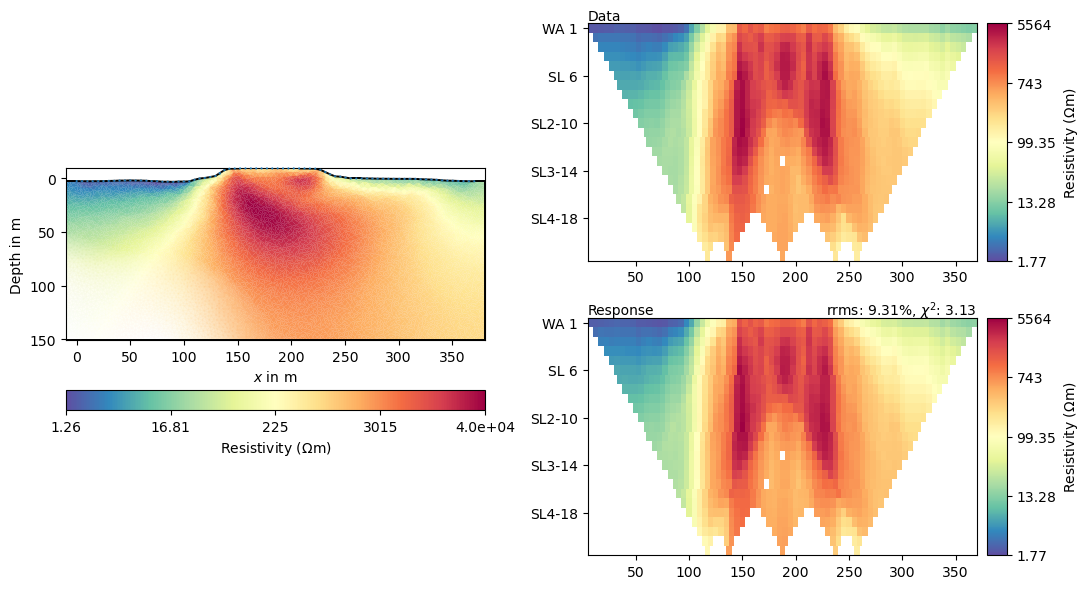

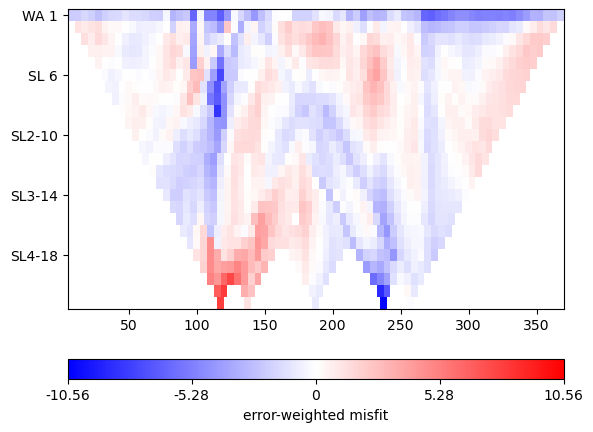

In [14]:
mgr.setMesh(mesh)
mgr.invert(data, lam=110, verbose=True, zWeight=0.5)
mgr.showResultAndFit()
mgr.showMisfit(errorWeighted=True)